# 📊 EDA

## 🎯 目的
データを眺めてコンペの理解を深める

---

## 🏆 コンペティションの目的

本コンペティションの目的は、**有機分子の相転移挙動を予測**し、材料探索を加速させることです。

具体的には、以下の2つのタスクに取り組みます:

1. **サーモトロピック液晶 (Thermotropic LC) 相を示す分子を特定**
2. **透明点 (Clearing Point) の予測** - 液晶相から等方性液体へと転移する温度

---

## 🔬 背景

液晶とは、結晶固体と等方性液体の中間に位置する物質ないしそのような物質の状態を示します。

### 💡 応用分野
- 現代のディスプレイ技術 (LCD)
- 光学デバイス
- センサー

### ⚠️ 課題
新規の液晶材料の探索は、従来、時間のかかる合成と熱分析を繰り返す**トライ・アンド・エラーのプロセス**に依存してきました。

本コンペティションでは、化学構造式 (SMILES) やその他の情報を解析し、以下の2点を行います:

1. **分類 (Classification)**: その分子がサーモトロピック液晶である確率を判定する
2. **回帰 (Regression)**: 液晶候補となる分子の透明点 (℃) を予測する

優れたモデルは、「空振り (不要な実験)」のコストと、「見逃し (有望な材料の看過)」のリスクのバランスを取りながら、実験合成すべき有望な候補を優先順位付けすることで、**材料探索の加速に貢献**します。

---

## 📝 タスク

各分子に対して、`[確率, 温度]` という単一のリストを出力してください。

- **確率 (probability)**: その分子がサーモトロピック液晶である確信度 (0.0 から 1.0)
- **温度 (temperature)**: 予測される透明点 (摂氏)

---

## 📈 Evaluation

### 🎯 指標: Decoupled Rank Score

本コンペティションでは、分類と回帰それぞれの「順序付け能力 (Ranking Capability)」を独立に評価し、それらを統合した **Decoupled Rank Score** を使用します。

この指標は、絶対値の誤差 (MAE など) ではなく、次のような「順位」を評価します:

- ✅ 高い確率を予測したものが本当に液晶か
- ✅ 高い温度を予測したものが本当に高温か

**スコア範囲**: -1.0 から +1.0 (値が大きいほど優れたモデル)

---

### 1️⃣ 提出フォーマット

各 `row_id` に対して、2つの値を含むリストの文字列表現 `[probability, temperature]` を予測してください。

- `probability`: その分子がサーモトロピック液晶である可能性を示す 0.0 から 1.0 の浮動小数点数
- `temperature`: 予測される透明点 (℃) を示す浮動小数点数

> ⚠️ **注意**: 非液晶と予測する場合 (確率が低い場合) でも、提出フォーマット上は温度 (例: 0.0) を含める必要があります。非液晶サンプルの温度予測は回帰パートの計算から除外されます。

**提出例**:
```csv
row_id,prediction
891,"[0.05, 0.0]"
892,"[0.88, 145.5]"
893,"[0.45, 120.0]"
...
```

---

### 2️⃣ スコアリングのロジック

最終スコアは、以下2つの指標の**等重み平均 (0.5 ずつ)** で計算されます。

#### 📊 パートA: 分類タスク (Classification)

全データを対象に、予測確率と正解ラベル (1: 液晶、0: 非液晶) から **正規化ジニ係数 (Normalized Gini)** を計算します。ROC AUC を用いて次のように定義します:

$$
\text{Normalized Gini} = 2 \times \text{AUC} - 1
$$

- **範囲**: -1.0 〜 +1.0
- **解釈**: 
  - ランダム予測は 0.0
  - 完全に正しく順位付けできると 1.0
  - 完全に逆順だと -1.0

---

#### 📈 パートB: 回帰タスク (Regression)

正解が液晶 (ラベルが 1) のデータのみを対象に、真の透明点と予測温度の **スピアマン順位相関係数 (Spearman's rho)** を計算します。

- **対象**: 正解が非液晶 (ラベルが 0) のサンプルは回帰評価から除外され、温度予測は一切影響しません
- **特徴**: 絶対値のズレ (バイアス) は無視され、液晶サンプル内での温度の大小関係 (順位) が合っているかを評価します

**定義 (順位相関としての定義)**:

$$
\rho = \text{corr}\Big(\text{rank}(t), \text{rank}(\hat{t})\Big)
$$

**参考 (同順位が無い場合の等価表現)**:

$$
\rho = 1 - \frac{6 \sum_i d_i^2}{n(n^2 - 1)}
$$

ここで、$d_i$ は真値順位と予測順位の差、$n$ は回帰評価の対象となる液晶サンプル数です。

---

### 3️⃣ 最終スコア (Final Score)

最終スコアは上記2指標の単純平均です:

$$
\text{Final Score} = \frac{\text{Normalized Gini} + \text{Spearman's } \rho}{2}
$$

**スコアの解釈**:
- **0.0**: ランダム予測 (NormGini が 0.0、Spearman が 0.0 の平均)
- **1.0**: 完全な予測 (NormGini が 1.0、Spearman が 1.0 の平均)

---

In [1]:
# ======================
# import libraries
# ======================
# General
import os, gc, re, yaml, glob, pickle, warnings
import time
import random, math
import joblib, pickle, itertools
from pathlib import Path

# データ読み込み用
import numpy as np
import scipy as sp
import polars as pl
import pandas as pd
from tqdm import tqdm

# Config用
from types import SimpleNamespace
from typing import Union, Any

# 化学系ライブラリ
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

# 可視化用
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib_fontja

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, StratifiedKFold, train_test_split
import warnings
# warnings.filterwarnings('ignore')

from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
print(f"TODAY is {date}")

TODAY is 20251223


In [2]:
# ===============
# Config
# ===============
config = SimpleNamespace(
    data_dir = Path("/kaggle/input/data-science-osaka-winter-2025"),
    seed = 42,
    n_splits = 5,
)

In [3]:
# ========== 汎用表示・ログ系 ==========
def sep(word: str, num: int = 80):
    print("=" * num)
    print(word)
    print("=" * num)

def show_df(df: Union[pd.DataFrame, pl.DataFrame], num: int = 3, show_tail: bool = False):
    """データフレームの概要を表示"""
    print(df.shape)
    display(df.head(num))
    if show_tail:
        display(df.tail(num))


# ========== ファイル操作 ==========
def glob_walk(root: Union[str, Path], pattern: str) -> list[Path]:
    """指定パターンにマッチするファイルパスを取得"""
    path = Path(root)
    return sorted(list(path.glob(pattern)))

# ========== seed固定 ==========
def seed_everything(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything(seed=config.seed)    

---

# 1. Read data(データの読み込み)

## 📂 データセット詳細

### 📋 基本情報

#### ファイル一覧

| ファイル名 | 説明 |
|:---|:---|
| **train.csv** | 学習データ。相転移挙動や透明点などの情報を含む |
| **test.csv** | テストデータ。相転移挙動や透明点などの情報を含まない<br>⚠️ test.csvに含まれるサーモトロピック液晶は必ず透明点を持つ（熱分解するものやモノトロピックは含まれない） |
| **supplemental.csv** | 参考データ。サーモトロピック液晶性を示すことが示唆されながらも等方相転移より先に熱分解する等の理由で透明点を含まないデータ。必要に応じて活用可能 |
| **sample_submission.csv** | 提出フォーマット確認用ファイル。`prediction`に予測値を代入することで間違いを防げる |

### ⚠️ 注意事項

相転移温度等はPOM or DSCの区別をしていません。また、昇温過程 or 降温過程かも明確とは限りません。ややラフなデータと言えますが、現実でも遭遇し得るある種のいい加減さと考えて対応してください。

---

### 🎓 train.csv (学習データ)
**データ数**: 1,020行

| カラム名 | データ型 | 意味 | 単位 | サンプル | null数 |
|:---|:---:|:---|:---:|:---|:---|
| `row_id` | Integer | 行ID（一意の識別子） | - | 1 | - |
| `compound_name` | String | 化合物名 | - | "4-Cyano-4'-pentylbiphenyl" | - |
| `smiles_guess` | String | SMILES表記（分子構造の文字列表現） | - | "CCCCCc1ccc(cc1)..." | - |
| `lc_type` | String | 液晶のタイプ | - | "Nematic" | 839 |
| `phase_transition_behavior` | String | 相転移挙動の詳細 | - | "Cr 24 N 35 Iso" | 425 |
| `description` | String | 化合物の説明・備考 | - | "Common LCD material" | - |
| `smiles_source` | String | SMILES情報の出典 | - | "PubChem" | 21 |
| `group_id` | String | グループID（関連化合物のグループ分け） | - | "group_A" | - |
| ⭐️`is_liquid_crystal` | Boolean | 液晶かどうか | - | true | - |
| `is_thermotropic_lc` | Integer | サーモトロピック液晶かどうか（0 or 1） | - | 1 | - |
| ⭐️`clearing_point_celsius` | Float | 透明点（液晶→等方性液体への転移温度） | ℃ | 35.0 | 614 |

⭐️: 目的変数

---
## 🔑 重要なカラムの補足説明

### 🧬 SMILES (Simplified Molecular Input Line Entry System)
- 分子構造を一次元の文字列で表現する記法
- 例: `"CCCCCc1ccc(cc1)c2ccc(cc2)C#N"` → ビフェニル骨格を持つ液晶分子

### 🌡️ clearing_point_celsius（透明点）
- 液晶相から等方性液体相への転移温度
- **trainのみ存在**（testでは予測対象）
- supplementalでは欠損している場合がある

### 🏷️ is_thermotropic_lc
- 1: サーモトロピック液晶である
- 0: サーモトロピック液晶ではない
- **trainのみ存在**（testでは予測対象）

In [4]:
# ===============
# train.csv
# ===============
train_df = pl.read_csv(config.data_dir / "train.csv")
sep("train.csv"); show_df(train_df, 3, True); display(train_df.describe())

train.csv
(1020, 11)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
i64,str,str,str,str,str,str,str,bool,i64,f64
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
i64,str,str,str,str,str,str,str,bool,i64,f64
1017,"""NPG-d6""","""[2H]C([2H])([2H])C(CO)(CO)C([2…",null,"""Cr 39.1 PC 128.5 I""","""A derivative of 2,2-dimethyl-1…","""ChemRxiv_Gemini_v10""","""paper_0329""",false,0,null
1018,"""3,4-bis[(S)-2-methyloctyl]thio…","""CCCCCC[C@@H](C)Cc1cc(C[C@@H](C…",null,null,"""Dialkyl-substituted chiral thi…","""New_Gemini""","""paper_0460""",false,0,null
1019,"""2,5-Bis(3-dodecyl-2-thienyl)th…","""CCCCCCCCCCCCc1csc(-c2nc3sc(-c4…","""No-LC""",null,"""A thiazolo[5,4-d]thiazole deri…","""New_Gemini""","""paper_0121""",false,0,null


statistic,row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
str,f64,str,str,str,str,str,str,str,f64,f64,f64
"""count""",1020.0,"""1020""","""1020""","""839""","""595""","""1020""","""999""","""1020""",1020.0,1020.0,406.0
"""null_count""",0.0,"""0""","""0""","""181""","""425""","""0""","""21""","""0""",0.0,0.0,614.0
"""mean""",509.5,null,null,null,null,null,null,null,0.416667,0.304902,151.031281
"""std""",294.592939,null,null,null,null,null,null,null,null,0.460592,71.874363
"""min""",0.0,"""(+)-3-[(S)-(2-methylbutoxy)]th…","""*C(=CC#CC(=*)c1ccccc1)c1ccccc1""","""Lyotropic""","""13as (Ph.Ox.C*Cn series): on h…","""(R, R)-1 is an aromatic scaffo…","""ChemRxiv_Gemini_v10""","""paper_0003""",0.0,0.0,-4.5
"""25%""",255.0,null,null,null,null,null,null,null,null,0.0,97.0
"""50%""",510.0,null,null,null,null,null,null,null,null,0.0,147.5
"""75%""",764.0,null,null,null,null,null,null,null,null,1.0,201.3
"""max""",1019.0,"""trans-perinone (Pigment Orange…","""c1csc(-c2nnc(N=Nc3ccc4ccccc4c3…","""Thermotropic""","""starts to melt at 29.8°C direc…","""trans-Perinone (Pigment Orange…","""PubChem""","""paper_0588""",1.0,1.0,420.0


### 🧪 test.csv (テストデータ)
**データ数**: 1,127行

| カラム名 | データ型 | 意味 | 単位 | サンプル | null数 |
|:---|:---:|:---|:---:|:---|:---|
| `row_id` | Integer | 行ID（一意の識別子） | - | 891 | - |
| `compound_name` | String | 化合物名 | - | "Unknown compound A" | - |
| `smiles_guess` | String | SMILES表記（分子構造の文字列表現） | - | "CCCCCc1ccc(cc1)..." | - |
| `description` | String | 化合物の説明・備考 | - | "Novel synthesized material" | - |
| `smiles_source` | String | SMILES情報の出典 | - | "Literature" | 41 |
| `group_id` | String | グループID（関連化合物のグループ分け） | - | "group_B" | - |

> 💡 **trainとの違い**: `lc_type`, `phase_transition_behavior`, `is_liquid_crystal`, `is_thermotropic_lc`, `clearing_point_celsius` のカラムが存在しない（これらを予測するのがタスク）

---

In [5]:
# ===============
# test.csv
# ===============
test_df = pl.read_csv(config.data_dir / "test.csv")
sep("test.csv"); show_df(test_df, 3, False); display(test_df.describe())

test.csv
(1127, 6)


row_id,compound_name,smiles_guess,description,smiles_source,group_id
i64,str,str,str,str,str
1020,"""Supramolecular complex of 4-[(…","""CCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(…","""A 1:1 supramolecular complex f…","""New_Gemini""","""paper_0491"""
1021,"""2,3,6,7,14,15-hexahydroxycyclo…","""Oc1cc2c(cc1O)Cc1cc(O)c(O)cc1Cc…","""A bowl-shaped macrocyclic orga…","""New_Gemini""","""paper_0578"""
1022,"""n-4O3""","""CCCCOCCCNC(NCCCOCCCC)=c1ccc(=C…","""n-4O3 is an aromatic organic s…","""ChemRxiv_Gemini_v10""","""paper_0291"""


statistic,row_id,compound_name,smiles_guess,description,smiles_source,group_id
str,f64,str,str,str,str,str
"""count""",1127.0,"""1127""","""1127""","""1127""","""1086""","""1127"""
"""null_count""",0.0,"""0""","""0""","""0""","""41""","""0"""
"""mean""",1583.0,null,null,null,null,null
"""std""",325.481182,null,null,null,null,null
"""min""",1020.0,"""(1-Phenylethylammonium) cerium…","""*C(=O)c1cccc(N(*)CCCCCCCC)c1""","""1'',7''-Bis{4'-[(E)-2-(4-cyano…","""ChemRxiv_Gemini_v10""","""paper_0001"""
"""25%""",1302.0,null,null,null,null,null
"""50%""",1583.0,null,null,null,null,null
"""75%""",1865.0,null,null,null,null,null
"""max""",2146.0,"""α,α'-dihexyl-quaterthiophene""","""c1coc(-c2cc(-c3ccco3)cc(-c3ccc…","""α,α'-Dihexyl-quaterthiophene f…","""PubChem""","""paper_0584"""


### 📚 supplemental.csv (参考データ)
**データ数**: 213行

| カラム名 | データ型 | 意味 | 単位 | サンプル | null数 |
|:---|:---:|:---|:---:|:---|:---|
| `row_id` | Integer | 行ID（一意の識別子） | - | 2001 | - |
| `compound_name` | String | 化合物名 | - | "Decomposed LC material" | - |
| `smiles_guess` | String | SMILES表記（分子構造の文字列表現） | - | "CCCCCc1ccc(cc1)..." | - |
| `lc_type` | String | 液晶のタイプ | - | "Nematic" | - |
| `phase_transition_behavior` | String | 相転移挙動の詳細 | - | "Cr 50 N Dec" | 6 |
| `description` | String | 化合物の説明・備考 | - | "Decomposes before clearing" | - |
| `smiles_source` | String | SMILES情報の出典 | - | "Research paper" | 26 |
| `group_id` | String | グループID（関連化合物のグループ分け） | - | "group_C" | - |
| `is_liquid_crystal` | Boolean | 液晶かどうか | - | true | - |
| `is_thermotropic_lc` | Integer | サーモトロピック液晶かどうか（0 or 1） | - | 1 | - |
| `clearing_point_celsius` | Float | 透明点（熱分解等で欠損の可能性あり） | ℃ | NaN | 213 |

> 🔬 **特徴**: サーモトロピック液晶性を示すが、透明点に達する前に熱分解するなどの理由で `clearing_point_celsius` が欠損している可能性が高い

---

In [6]:
# ===============
# supplemental.csv
# ===============
supple_df = pl.read_csv(config.data_dir / "supplemental.csv")
sep("supplemental.csv"); show_df(supple_df, 3, False); display(supple_df.describe())

supplemental.csv
(213, 11)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
i64,str,str,str,str,str,str,str,bool,i64,str
2147,"""4-(4-hydroxybutyloxy)-4′-hydro…","""OCCCCOc1ccc(-c2ccc(O)cc2)cc1""","""Thermotropic""","""Monotropic LC behavior implies…","""The paper reviews the crystall…",null,"""paper_0445""",true,1,null
2148,"""Poly(ethylene glycol) grafted …","""COCCOCC(=O)OC[C@@H]1O[C@H](O)[…","""Thermotropic""","""Not reported/applicable in the…","""The material consists of a cel…","""New_Gemini""","""paper_0143""",true,1,null
2149,"""N,N',N''-tris(4-((E)-2-(4-((E)…","""CCCCCCCCCCCCOc1ccc(C=Cc2ccc(C=…","""Thermotropic""","""decomposition at clearing poin…","""The molecule consists of a ben…","""New_Gemini""","""paper_0514""",true,1,null


statistic,row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
str,f64,str,str,str,str,str,str,str,f64,f64,str
"""count""",213.0,"""213""","""213""","""213""","""207""","""213""","""187""","""213""",213.0,213.0,"""0"""
"""null_count""",0.0,"""0""","""0""","""0""","""6""","""0""","""26""","""0""",0.0,0.0,"""213"""
"""mean""",2253.0,null,null,null,null,null,null,null,1.0,1.0,null
"""std""",61.631972,null,null,null,null,null,null,null,null,0.0,null
"""min""",2147.0,"""((3R,3aS,6aS)-hexahydrofuro[3,…","""*CC(*)(C)C(=O)OCCCCCCOc1ccc(N=…","""Thermotropic""","""A DSC curve is referenced in t…","""1-(cis-7-hexadecenoyl)-rac-gly…","""ChemRxiv_Gemini_v10""","""paper_0002""",1.0,1.0,null
"""25%""",2200.0,null,null,null,null,null,null,null,null,1.0,null
"""50%""",2253.0,null,null,null,null,null,null,null,null,1.0,null
"""75%""",2306.0,null,null,null,null,null,null,null,null,1.0,null
"""max""",2359.0,"""rac-Ru-C9""","""[Ru+3]""","""Thermotropic""","""thermotropic liquid crystal ph…","""rac-Ru-C9 is an aromatic organ…","""PubChem""","""paper_0587""",1.0,1.0,null


### 📤 sample_submission.csv (提出フォーマット)
**データ数**: 1,127行（testと同数）

| カラム名 | データ型 | 意味 | 単位 | サンプル |
|:---|:---:|:---|:---:|:---|
| `row_id` | Integer | 行ID（testのrow_idと対応） | - | 891 |
| `prediction` | String | 予測値 `[probability, temperature]` の文字列表現 | - | `"[0.5, 100.0]"` |

> 📝 **提出時の注意**: `prediction` カラムには、`[確率, 温度]` の形式で文字列として記述する必要があります

---

# 2. Visualization(可視化)
---
可視化してデータをさらに理解する.

In [7]:
# =================
# データの結合
# =================
train_df = train_df.with_columns(pl.lit(True).alias("is_train"))
test_df = test_df.with_columns(pl.lit(False).alias("is_train"))

# diagonal: カラムが異なっていても結合可能
df = pl.concat([train_df, test_df], how="diagonal")
show_df(df)

(2147, 12)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius,is_train
i64,str,str,str,str,str,str,str,bool,i64,f64,bool
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0,true
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0,true
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0,true


In [8]:
# ==================================================
# Identify numerical and categorical columns
# ==================================================
numetric_cols = df.select(pl.selectors.numeric()).columns
print(f"Numerical columns: {numetric_cols}")
categorical_cols = [col for col in df.columns if col not in numetric_cols]
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['row_id', 'is_thermotropic_lc', 'clearing_point_celsius']
Categorical columns: ['compound_name', 'smiles_guess', 'lc_type', 'phase_transition_behavior', 'description', 'smiles_source', 'group_id', 'is_liquid_crystal', 'is_train']


In [9]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def show_venn2(df_0: pd.DataFrame, df_1: pd.DataFrame, col0: str, col1: str) -> None:
    """show venn2 visualization
    
    Args:
        df_0 (pd.DataFrame): DataFrame 0
        df_1 (pd.DataFrame): DataFrame 1
        col0 (str): name of DataFrame 0
        col1 (str): name of DataFrame 1
    """    
    # 共通のカラムのみを対象
    common_cols = [c for c in df_0.columns if c in df_1.columns]
    n_columns = len(common_cols)
    
    N_FIG_COL = 4
    N_FIG_ROW = -(-n_columns // N_FIG_COL)  # 切り上げ除算   
    fig, axes = plt.subplots(figsize=(3 * N_FIG_COL, 2.5 * N_FIG_ROW), 
                             ncols=N_FIG_COL, nrows=N_FIG_ROW)
    # axesを1次元配列に変換（1行の場合の対応）
    if N_FIG_ROW == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    for idx, c in enumerate(common_cols):
        ax = axes_flat[idx]
        ax.set_title(c, fontsize=10, fontweight='bold')
        # nullを除外してユニークな値を取得
        set_0 = set(df_0[c].dropna().unique())
        set_1 = set(df_1[c].dropna().unique())       
        # ベン図を描画
        try:
            venn2(subsets=(set_0, set_1), set_labels=(col0, col1), ax=ax)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:30]}', 
                   ha='center', va='center', fontsize=8)
            ax.axis('off')
    
    # 使わないサブプロットを非表示
    for idx in range(n_columns, len(axes_flat)):
        axes_flat[idx].axis('off')
    
    fig.tight_layout()
    plt.show()

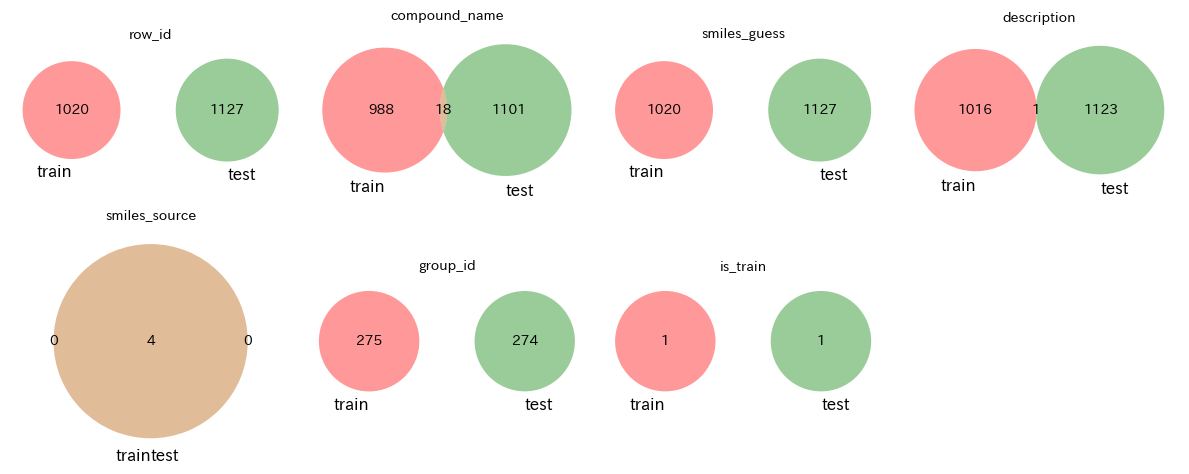

In [10]:
# ===============================
# venn2
# ===============================
show_venn2(train_df.to_pandas(), test_df.to_pandas(), "train", "test")

> 重複するデータはほとんど無い.  
> 一部、化合物名やdescriptionが重複しているが、以下の確認によるとデータとしては違うもののようだ.（異性体や類似化合物の可能性が高い？？知らんけど。）  

In [11]:
# 重複データの詳細確認

# compound_name の重複（18件）
print("="*60)
print("📝 compound_name の重複データ")
print("="*60)

# trainとtestで重複している化合物名
train_names = set(train_df['compound_name'].to_list())
test_names = set(test_df['compound_name'].to_list())
overlapping_names = train_names & test_names

print(f"\n重複している化合物数: {len(overlapping_names)}")
print("\n重複している化合物名:")
for idx, name in enumerate(sorted(overlapping_names), 1):
    print(f"  {idx:2d}. {name}")

# 重複データの詳細を表示
print("\n" + "="*60)
print("🔍 重複データの詳細情報")
print("="*60)

for name in sorted(overlapping_names)[:5]:  # 最初の5件のみ表示
    print(f"\n【{name}】")
    
    # trainのデータ
    train_row = train_df.filter(pl.col('compound_name') == name)
    print(f"  [Train] row_id: {train_row['row_id'][0]}")
    print(f"          is_liquid_crystal: {train_row['is_liquid_crystal'][0]}")
    print(f"          clearing_point: {train_row['clearing_point_celsius'][0]}")
    print(f"          SMILES: {train_row['smiles_guess'][0][:50]}...")
    
    # testのデータ
    test_row = test_df.filter(pl.col('compound_name') == name)
    print(f"  [Test]  row_id: {test_row['row_id'][0]}")
    print(f"          SMILES: {test_row['smiles_guess'][0][:50]}...")
    
    # SMILESが一致するか確認
    smiles_match = train_row['smiles_guess'][0] == test_row['smiles_guess'][0]
    print(f"  ✅ SMILES一致: {smiles_match}" if smiles_match else f"  ⚠️ SMILES不一致")

# すべての重複データを表で表示
print("\n" + "="*60)
print("📊 すべての重複データ一覧")
print("="*60)

overlap_data = []
for name in sorted(overlapping_names):
    train_row = train_df.filter(pl.col('compound_name') == name)
    test_row = test_df.filter(pl.col('compound_name') == name)
    
    overlap_data.append({
        'compound_name': name,
        'train_row_id': train_row['row_id'][0],
        'test_row_id': test_row['row_id'][0],
        'is_liquid_crystal': train_row['is_liquid_crystal'][0],
        'clearing_point': train_row['clearing_point_celsius'][0],
        'smiles_match': train_row['smiles_guess'][0] == test_row['smiles_guess'][0]
    })

overlap_df = pl.DataFrame(overlap_data)
display(overlap_df)

# SMILESの一致/不一致の集計
print("\n" + "="*60)
print("🔬 SMILES の一致状況")
print("="*60)
print(f"SMILES一致: {overlap_df['smiles_match'].sum()}件")
print(f"SMILES不一致: {(~overlap_df['smiles_match']).sum()}件")

# 液晶性の分布
print("\n" + "="*60)
print("💧 重複データの液晶性")
print("="*60)
lc_counts = overlap_df.group_by('is_liquid_crystal').agg(pl.len().alias('count'))
display(lc_counts)

📝 compound_name の重複データ

重複している化合物数: 18

重複している化合物名:
   1. Cellulose
   2. Cellulose nanocrystals
   3. Compound 10
   4. Compound 11
   5. Compound 4
   6. Compound 5
   7. Compound 6
   8. Compound 7
   9. Compound 8
  10. Compound 9
  11. Nanocrystalline cellulose
  12. Poly(3-hexylthiophene)
  13. Poly(3-hydroxybutyrate)
  14. Polyamide 11
  15. Polyamide 12
  16. Polyamide 4
  17. Polypyrrole
  18. RM230

🔍 重複データの詳細情報

【Cellulose】
  [Train] row_id: 623
          is_liquid_crystal: False
          clearing_point: None
          SMILES: OC[C@H]1O[C@@H](O[C@@H]2[C@H](O)[C@@H](O)[C@H](O)O...
  [Test]  row_id: 1366
          SMILES: OC[C@@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O[C@H]1O...
  ⚠️ SMILES不一致

【Cellulose nanocrystals】
  [Train] row_id: 24
          is_liquid_crystal: True
          clearing_point: None
          SMILES: OC[C@@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O...
  [Test]  row_id: 1129
          SMILES: OC[C@@H]1O[C@@H](O[C@H]2[C@H](O)[C@H](O)[C@@H](O)O...
  ⚠️ SMILES不一致

【Co

compound_name,train_row_id,test_row_id,is_liquid_crystal,clearing_point,smiles_match
str,i64,i64,bool,f64,bool
"""Cellulose""",623,1366,false,null,false
"""Cellulose nanocrystals""",24,1129,true,null,false
"""Compound 10""",678,1085,false,null,false
"""Compound 11""",11,1531,false,null,false
"""Compound 4""",659,1891,false,null,false
…,…,…,…,…,…
"""Polyamide 11""",158,1953,false,185.0,false
"""Polyamide 12""",566,2072,false,180.0,false
"""Polyamide 4""",737,1381,false,260.0,false



🔬 SMILES の一致状況
SMILES一致: 0件
SMILES不一致: 18件

💧 重複データの液晶性


is_liquid_crystal,count
bool,u32
false,15
true,3


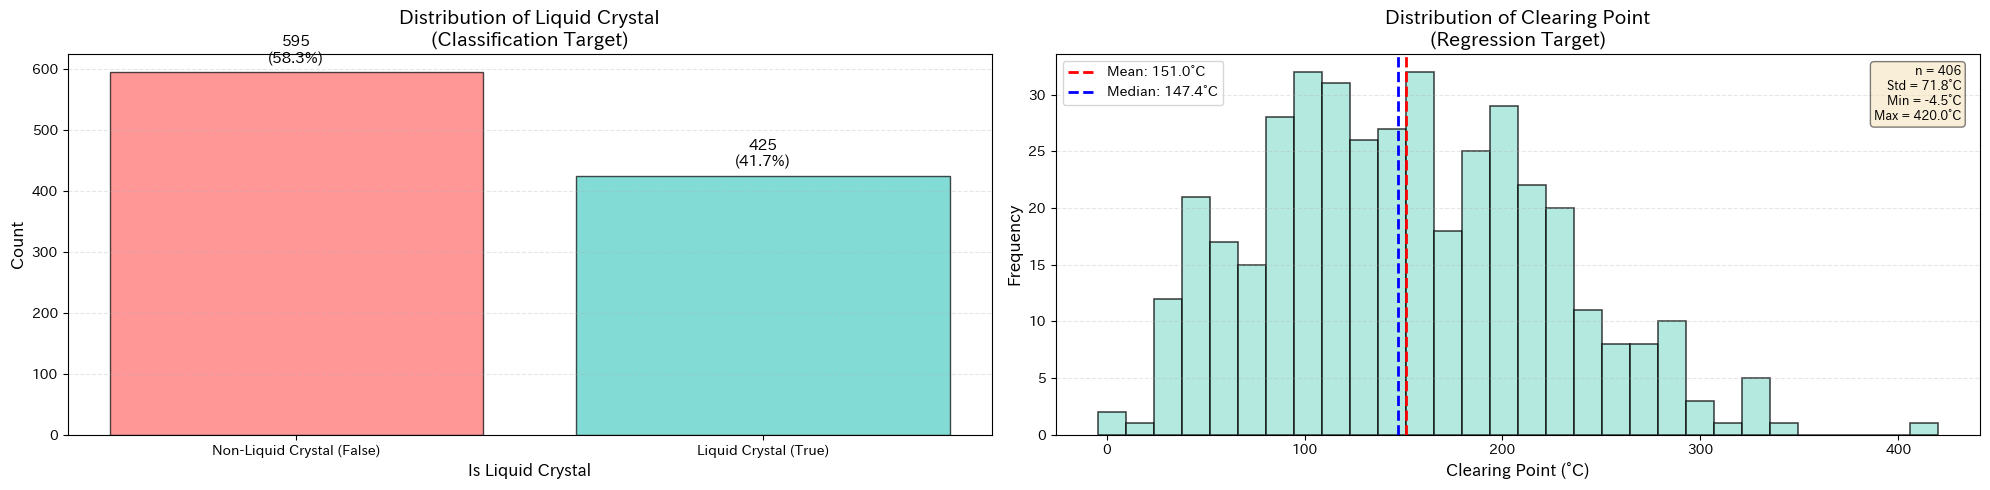

📊 Is Liquid Crystal の分布（分類タスクの目的変数）
shape: (2, 2)
┌───────────────────┬───────┐
│ is_liquid_crystal ┆ count │
│ ---               ┆ ---   │
│ bool              ┆ u32   │
╞═══════════════════╪═══════╡
│ false             ┆ 595   │
│ true              ┆ 425   │
└───────────────────┴───────┘

Liquid Crystal の割合: 41.67%
🌡️ Clearing Point (°C) の統計（回帰タスクの目的変数）
データ数: 406
平均値: 151.03°C
中央値: 147.40°C
標準偏差: 71.79°C
最小値: -4.50°C
最大値: 420.00°C
欠損値: 614


In [12]:
# フィギュアとサブプロットを作成（2列に変更）
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# ===== 左側: is_liquid_crystal の棒グラフ =====
# データの集計
liquid_crystal_counts = train_df.group_by("is_liquid_crystal").agg(
    pl.len().alias("count")
).sort("is_liquid_crystal")

# 棒グラフ
labels_lc = ['Non-Liquid Crystal (False)', 'Liquid Crystal (True)']
counts_lc = liquid_crystal_counts["count"].to_list()
colors_lc = ['#FF6B6B', '#4ECDC4']

axes[0].bar(labels_lc, counts_lc, color=colors_lc, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Is Liquid Crystal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Liquid Crystal\n(Classification Target)', 
                   fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# 値をバーの上に表示
for i, (label, count) in enumerate(zip(labels_lc, counts_lc)):
    axes[0].text(i, count + 10, f'{count}\n({count/sum(counts_lc)*100:.1f}%)', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# ===== 右側: clearing_point_celsius のヒストグラム =====
# nullを除外
clearing_points = train_df.filter(
    pl.col("clearing_point_celsius").is_not_null()
)["clearing_point_celsius"].to_numpy()

# ヒストグラム
axes[1].hist(clearing_points, bins=30, color='#95E1D3', alpha=0.7, 
             edgecolor='black', linewidth=1.2)
axes[1].set_xlabel('Clearing Point (°C)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Clearing Point\n(Regression Target)', 
                   fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# 統計情報を追加
mean_val = np.mean(clearing_points)
median_val = np.median(clearing_points)
axes[1].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}°C')
axes[1].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}°C')
axes[1].legend(fontsize=10)

# 統計情報をテキストで表示
stats_text = f'n = {len(clearing_points)}\nStd = {np.std(clearing_points):.1f}°C\nMin = {np.min(clearing_points):.1f}°C\nMax = {np.max(clearing_points):.1f}°C'
axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 全体の調整
plt.tight_layout()
plt.savefig('liquid_crystal_clearing_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 追加情報の表示 =====
sep("📊 Is Liquid Crystal の分布（分類タスクの目的変数）")
print(liquid_crystal_counts)
print(f"\nLiquid Crystal の割合: {counts_lc[1]/sum(counts_lc)*100:.2f}%")

sep("🌡️ Clearing Point (°C) の統計（回帰タスクの目的変数）")
print(f"データ数: {len(clearing_points)}")
print(f"平均値: {mean_val:.2f}°C")
print(f"中央値: {median_val:.2f}°C")
print(f"標準偏差: {np.std(clearing_points):.2f}°C")
print(f"最小値: {np.min(clearing_points):.2f}°C")
print(f"最大値: {np.max(clearing_points):.2f}°C")
print(f"欠損値: {train_df.filter(pl.col('clearing_point_celsius').is_null()).height}")

📊 lc_type の分析
ユニーク値の数: 4

📈 is_liquid_crystal の分布:
shape: (5, 3)
┌──────────────┬───────────────────┬───────┐
│ lc_type      ┆ is_liquid_crystal ┆ count │
│ ---          ┆ ---               ┆ ---   │
│ str          ┆ bool              ┆ u32   │
╞══════════════╪═══════════════════╪═══════╡
│ Lyotropic    ┆ false             ┆ 1     │
│ Lyotropic    ┆ true              ┆ 86    │
│ Monotropic   ┆ true              ┆ 28    │
│ No-LC        ┆ false             ┆ 413   │
│ Thermotropic ┆ true              ┆ 311   │
└──────────────┴───────────────────┴───────┘

🌡️ clearing_point_celsius の統計:
shape: (4, 7)
┌──────────────┬───────┬────────────┬────────┬───────────┬──────┬────────┐
│ lc_type      ┆ count ┆ mean       ┆ median ┆ std       ┆ min  ┆ max    │
│ ---          ┆ ---   ┆ ---        ┆ ---    ┆ ---       ┆ ---  ┆ ---    │
│ str          ┆ u32   ┆ f64        ┆ f64    ┆ f64       ┆ f64  ┆ f64    │
╞══════════════╪═══════╪════════════╪════════╪═══════════╪══════╪════════╡
│ Lyotropic    ┆ 5 

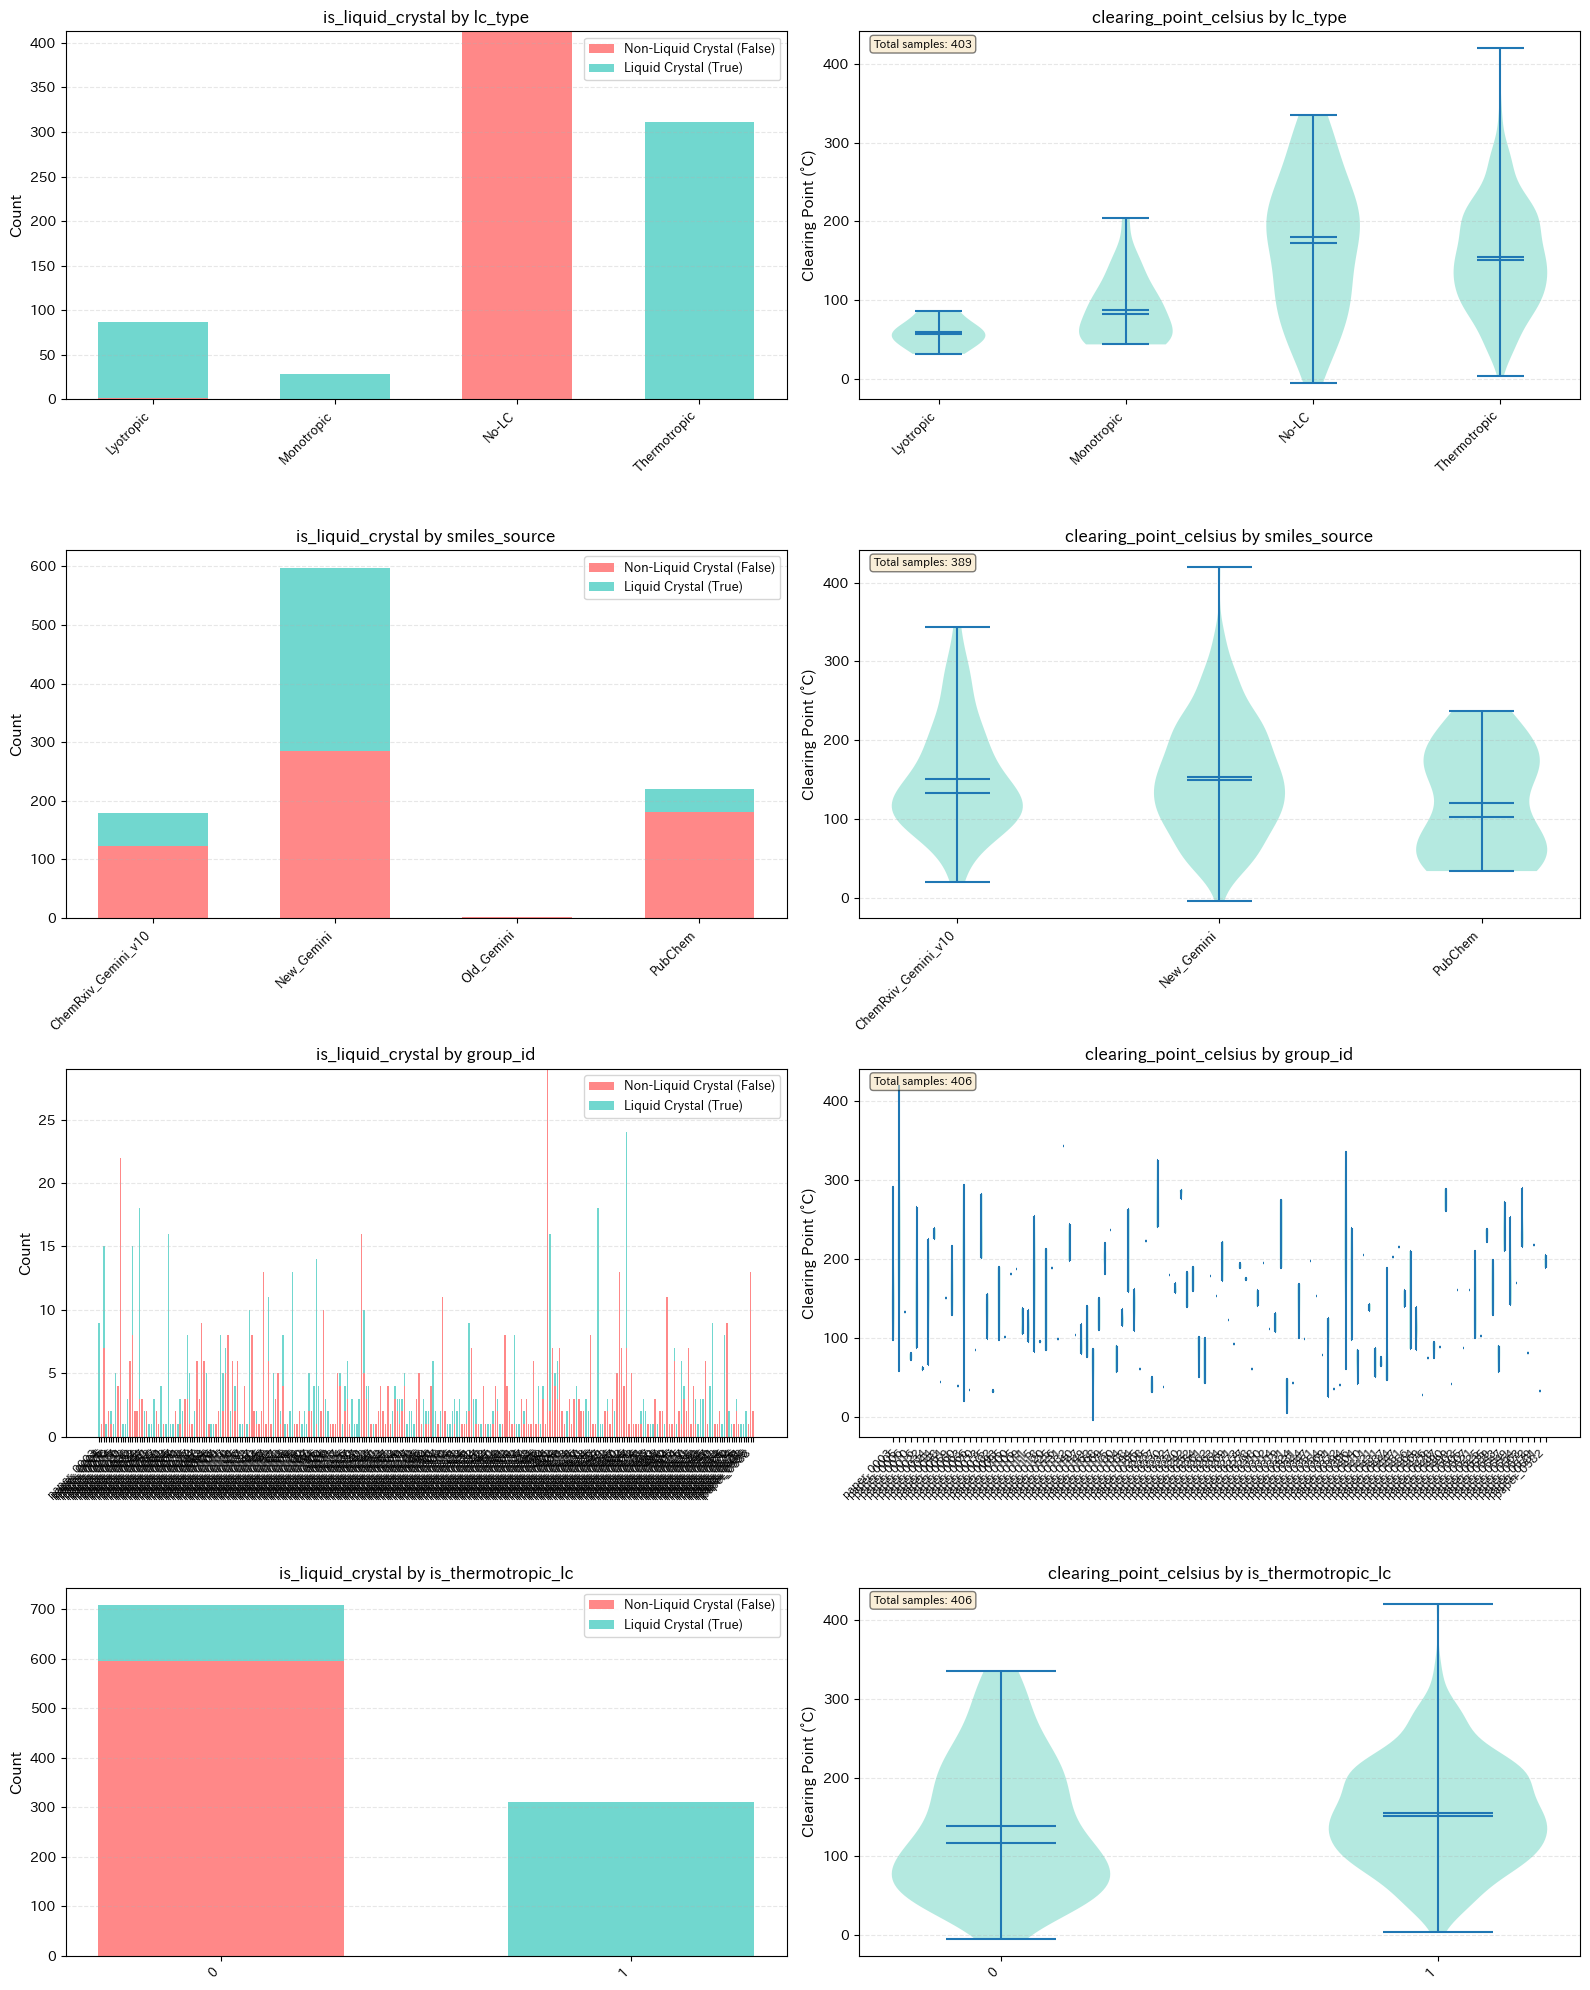

In [13]:
def visualize_target_by_features(df: pl.DataFrame):
    """
    各特徴量ごとのis_liquid_crystalとclearing_point_celsiusの分布を可視化
    """
    # 可視化対象の特徴量
    features = ['lc_type', 'smiles_source', 'group_id', 'is_thermotropic_lc']
    
    # 2列（is_liquid_crystal, clearing_point_celsius）× 4行（各特徴量）
    fig, axes = plt.subplots(len(features), 2, figsize=(16, 5 * len(features)))
    
    for idx, feature in enumerate(features):
        sep(f"📊 {feature} の分析")       
        # nullを除外してユニークな値を取得
        feature_data = df.filter(pl.col(feature).is_not_null())
        unique_values = feature_data[feature].unique().sort().to_list()
        print(f"ユニーク値の数: {len(unique_values)}")
        
        # === 左側: is_liquid_crystal の分布 ===
        ax_left = axes[idx, 0]
        
        # 各カテゴリごとの is_liquid_crystal の集計
        grouped_data = feature_data.group_by([feature, 'is_liquid_crystal']).agg(
            pl.len().alias('count')
        ).sort([feature, 'is_liquid_crystal'])
        
        # データをピボット形式に変換（pandas経由）
        pivot_data = grouped_data.to_pandas().pivot(
            index=feature, 
            columns='is_liquid_crystal', 
            values='count'
        ).fillna(0)
        
        # 積み上げ棒グラフ
        x_pos = np.arange(len(pivot_data))
        width = 0.6
        
        # False: Non-Liquid Crystal, True: Liquid Crystal
        bottom_vals = np.zeros(len(pivot_data))
        colors = ['#FF6B6B', '#4ECDC4']
        labels = ['Non-Liquid Crystal (False)', 'Liquid Crystal (True)']
        
        for col_idx, col in enumerate([False, True]):
            if col in pivot_data.columns:
                values = pivot_data[col].values
                ax_left.bar(x_pos, values, width, label=labels[col_idx], 
                           color=colors[col_idx], alpha=0.8, bottom=bottom_vals)
                bottom_vals += values
        
        # x軸のラベル設定（長い場合は回転）
        if len(unique_values) > 10:
            ax_left.set_xticks(x_pos)
            ax_left.set_xticklabels([str(v)[:20] for v in pivot_data.index], 
                                    rotation=45, ha='right', fontsize=8)
        else:
            ax_left.set_xticks(x_pos)
            ax_left.set_xticklabels([str(v) for v in pivot_data.index], 
                                    rotation=45, ha='right', fontsize=9)
        
        ax_left.set_ylabel('Count', fontsize=11, fontweight='bold')
        ax_left.set_title(f'is_liquid_crystal by {feature}', 
                         fontsize=12, fontweight='bold')
        ax_left.legend(loc='upper right', fontsize=9)
        ax_left.grid(axis='y', alpha=0.3, linestyle='--')
        
        # === 右側: clearing_point_celsius の分布（箱ひげ図またはバイオリンプロット）===
        ax_right = axes[idx, 1]
        
        # clearing_point が存在するデータのみ
        temp_data = feature_data.filter(
            pl.col('clearing_point_celsius').is_not_null()
        )
        
        if temp_data.height > 0:
            # 各カテゴリごとの温度データを取得
            box_data = []
            box_labels = []
            
            for val in unique_values:
                temps = temp_data.filter(
                    pl.col(feature) == val
                )['clearing_point_celsius'].to_list()
                
                if len(temps) > 0:
                    box_data.append(temps)
                    box_labels.append(str(val)[:20])
            
            if box_data:
                # バイオリンプロット
                parts = ax_right.violinplot(box_data, positions=range(len(box_data)),
                                            showmeans=True, showmedians=True)
                
                # 色付け
                for pc in parts['bodies']:
                    pc.set_facecolor('#95E1D3')
                    pc.set_alpha(0.7)
                
                # x軸のラベル
                ax_right.set_xticks(range(len(box_labels)))
                if len(box_labels) > 10:
                    ax_right.set_xticklabels(box_labels, rotation=45, ha='right', fontsize=8)
                else:
                    ax_right.set_xticklabels(box_labels, rotation=45, ha='right', fontsize=9)
                
                ax_right.set_ylabel('Clearing Point (°C)', fontsize=11, fontweight='bold')
                ax_right.set_title(f'clearing_point_celsius by {feature}', 
                                  fontsize=12, fontweight='bold')
                ax_right.grid(axis='y', alpha=0.3, linestyle='--')
                
                # 統計情報を表示
                stats_text = f'Total samples: {len([t for temps in box_data for t in temps])}'
                ax_right.text(0.02, 0.98, stats_text, transform=ax_right.transAxes,
                            fontsize=8, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            else:
                ax_right.text(0.5, 0.5, 'No clearing point data available',
                            ha='center', va='center', fontsize=12)
                ax_right.axis('off')
        else:
            ax_right.text(0.5, 0.5, 'No clearing point data available',
                        ha='center', va='center', fontsize=12)
            ax_right.axis('off')
        
        # 統計情報を出力
        print(f"\n📈 is_liquid_crystal の分布:")
        print(grouped_data.sort([feature, 'is_liquid_crystal']))
        
        if temp_data.height > 0:
            print(f"\n🌡️ clearing_point_celsius の統計:")
            temp_stats = temp_data.group_by(feature).agg([
                pl.col('clearing_point_celsius').count().alias('count'),
                pl.col('clearing_point_celsius').mean().alias('mean'),
                pl.col('clearing_point_celsius').median().alias('median'),
                pl.col('clearing_point_celsius').std().alias('std'),
                pl.col('clearing_point_celsius').min().alias('min'),
                pl.col('clearing_point_celsius').max().alias('max')
            ]).sort(feature)
            print(temp_stats)
    
    plt.tight_layout()
    plt.savefig('target_distribution_by_features.png', dpi=300, bbox_inches='tight')
    plt.show()


# 実行
visualize_target_by_features(train_df)

# 3. SMILESを基にした特徴量設計 🔬

`smiles_guess` から液晶性予測に有効な分子特徴量を抽出.

---

## 🧪 抽出済み分子特徴量一覧

### 📋 基本的な分子記述子

| カテゴリ | 特徴量名 | 説明 | 液晶材料との関連性 |
|:---|:---|:---|:---|
| **🔷 分子の形状・剛性** | `num_aromatic_rings` | 芳香環の数 | 液晶は棒状分子が多く、芳香環が分子の剛直性を高める |
| | `num_aliphatic_rings` | 脂肪族環の数 | 非芳香族環の存在 |
| | `num_rings` | 総環数 | 環構造の複雑さ |
| | `num_saturated_rings` | 飽和環の数 | 飽和環構造の有無 |
| | `num_aromatic_carbocycles` | 芳香族炭素環の数 | ベンゼン環などの数 |
| | `num_aromatic_heterocycles` | 芳香族複素環の数 | ピリジン環などの数 |
| | `num_heterocycles` | 複素環の数 | N,O,S等を含む環 |
| | `num_rotatable_bonds` | 回転可能結合の数 | 分子の柔軟性。多すぎると液晶性低下 |
| | `fraction_csp3` | 飽和炭素（sp3炭素）の割合 | 低いほど平面性・剛直性が高い |
| **📏 分子サイズ** | `mol_weight` | 分子量 (Da) | 適度な分子量が液晶性に重要 |
| | `num_atoms` | 全原子数 | 分子の大きさ（水素含む） |
| | `num_heavy_atoms` | 重原子数 | 分子の大きさ（H以外） |
| | `smiles_length` | SMILES文字列の長さ | 分子の複雑さの簡易指標 |
| **🧬 元素組成** | `num_carbons` | 炭素原子の数 | 有機分子の骨格 |
| | `num_nitrogens` | 窒素原子の数 | シアノ基などに含まれる |
| | `num_oxygens` | 酸素原子の数 | エステル、エーテル結合など |
| | `num_sulfurs` | 硫黄原子の数 | チオ基などに含まれる |
| | `num_halogens` | ハロゲン原子の数 | F, Cl, Br, I の総数 |
| **⚡ 極性・相互作用** | `logP` | 脂溶性（疎水性） | 分子間相互作用の強さに影響 |
| | `tpsa` | 極性表面積 (Ų) | 極性相互作用の強さ |
| | `molar_refractivity` | モル屈折率 | 分子の分極率 |
| | `num_h_acceptors` | 水素結合受容体の数 | 分子間水素結合能 |
| | `num_h_donors` | 水素結合供与体の数 | 分子間水素結合能 |
| **🔍 構造の有無** | `has_benzene_ring` | ベンゼン環の有無 | 芳香族性の基本単位 |
| | `has_double_bond` | C=C二重結合の有無 | 不飽和度 |
| | `has_triple_bond` | C≡C, C≡N三重結合の有無 | シアノ基やアルキン |

---

### 🔬 液晶材料に特化した官能基特徴量

| 特徴量名 | 説明 | 液晶材料との関連性 |
|:---|:---|:---|
| `has_cyano_group` | シアノ基（-CN）の有無 | **極めて重要**: LCD材料で頻繁に使用される極性基 |
| `has_biphenyl` | ビフェニル骨格の有無 | **重要**: 代表的な液晶コア構造（5CB等） |
| `has_ester` | エステル結合（-COO-）の有無 | 液晶材料の連結基として使用 |
| `has_ether` | エーテル結合（-O-）の有無 | 柔軟性を付与する連結基 |
| `has_nitro` | ニトロ基（-NO₂）の有無 | 強い電子吸引性基 |
| `has_fluorine` | フッ素原子の有無 | 低誘電率、高電圧保持率 |
| `max_alkyl_chain_length` | 最長アルキル鎖の炭素数 | **重要**: 液晶の流動性・転移温度を調整 |

---

## 🎯 液晶材料予測における特徴量の重要度

### ✅ 高相関が観測された特徴量

| 特徴量 | 実測された関係性 | 重要度 |
|:---|:---|:---:|
| `num_aromatic_rings` | ✅ **正の相関**: 芳香環が多いほど液晶性が高い | ⭐⭐⭐ |
| `has_cyano_group` | ✅ **強い正の相関**: 液晶ディスプレイ材料で頻用 | ⭐⭐⭐ |
| `has_biphenyl` | ✅ **正の相関**: 代表的な液晶骨格 | ⭐⭐⭐ |
| `num_rotatable_bonds` | ⚠️ **非線形関係**: 適度な柔軟性が必要 | ⭐⭐ |
| `mol_weight` | ⚠️ **適度な範囲**: 200-500 Da 程度が多い | ⭐⭐ |
| `logP` | ✅ **正の相関**: 適度な疎水性が液晶相形成に有利 | ⭐⭐ |
| `fraction_csp3` | ❌ **負の相関**: 飽和炭素が多いと平面性低下 | ⭐⭐ |
| `max_alkyl_chain_length` | ✅ **正の相関**: 長鎖アルキル基が液晶性を高める | ⭐⭐ |
| `tpsa` | ⚠️ **適度な範囲**: 極性が強すぎても弱すぎても不利 | ⭐ |

### 📊 透明点（clearing_point_celsius）との相関

| 特徴量 | 相関係数 | 傾向 |
|:---|:---:|:---|
| `mol_weight` | 🔥 | 分子量が大きいほど透明点が高い傾向 |
| `num_aromatic_rings` | 🔥 | 芳香環が多いほど透明点が高い |
| `num_rotatable_bonds` | 💧 | 柔軟性が高いと透明点が低下 |
| `logP` | 🔥 | 疎水性が高いと透明点が高い傾向 |

> 🔥: 正の相関 / 💧: 負の相関

---

## 💡 今後追加可能な高度な特徴量（未実装）

| 特徴量名 | 説明 | 実装方法 | 期待される効果 |
|:---|:---|:---|:---|
| `aspect_ratio` | 分子の縦横比（細長さ） | 3D座標生成 → 主軸計算 | 棒状性の定量化 |
| `molecular_eccentricity` | 分子の偏心率 | 主慣性モーメント比 | 異方性の指標 |
| `num_terminal_groups` | 末端基の数 | グラフ理論 | 分子端の特性 |
| `dipole_moment` | 双極子モーメント | 量子化学計算 | 分子の極性度 |
| `planarity_score` | 平面性スコア | 原子座標から計算 | 液晶性の重要指標 |

---

In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, Crippen
from rdkit.Chem import AllChem

def extract_functional_groups(mol) -> dict:
    """
    特定の官能基の有無を検出
    
    Args:
        mol: RDKit分子オブジェクト
    
    Returns:
        官能基情報の辞書
    """
    if mol is None:
        return {
            'has_cyano_group': False,
            'has_biphenyl': False,
            'has_ester': False,
            'has_ether': False,
            'has_nitro': False,
            'has_fluorine': False,
            'max_alkyl_chain_length': 0,
        }
    
    features = {
        # 液晶材料で重要な官能基
        'has_cyano_group': mol.HasSubstructMatch(Chem.MolFromSmarts('C#N')),
        'has_biphenyl': mol.HasSubstructMatch(Chem.MolFromSmarts('c1ccc(cc1)c2ccccc2')),
        'has_ester': mol.HasSubstructMatch(Chem.MolFromSmarts('C(=O)O')),
        'has_ether': mol.HasSubstructMatch(Chem.MolFromSmarts('COC')),
        'has_nitro': mol.HasSubstructMatch(Chem.MolFromSmarts('[N+](=O)[O-]')),
        'has_fluorine': mol.HasSubstructMatch(Chem.MolFromSmarts('[F]')),
    }
    
    # 最長アルキル鎖の長さを計算
    # C3以上の連続アルキル鎖を検出
    alkyl_lengths = []
    for n in range(3, 21):  # C3からC20まで検索
        pattern = 'C' * n
        if mol.HasSubstructMatch(Chem.MolFromSmarts(pattern)):
            alkyl_lengths.append(n)
    
    features['max_alkyl_chain_length'] = max(alkyl_lengths, default=0)
    
    return features


def extract_molecular_features(smiles: str) -> dict:
    """
    SMILES文字列から分子特徴量を抽出
    
    Args:
        smiles: SMILES文字列
    
    Returns:
        特徴量の辞書
    """
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        # 無効なSMILESの場合はNaNを返す
        return {
            # 基本的な記述子
            'mol_weight': np.nan,
            'num_atoms': np.nan,
            'num_heavy_atoms': np.nan,
            'num_carbons': np.nan,
            'num_nitrogens': np.nan,
            'num_oxygens': np.nan,
            'num_sulfurs': np.nan,
            'num_halogens': np.nan,
            'num_aromatic_rings': np.nan,
            'num_aliphatic_rings': np.nan,
            'num_rings': np.nan,
            'num_rotatable_bonds': np.nan,
            'num_h_acceptors': np.nan,
            'num_h_donors': np.nan,
            'logP': np.nan,
            'tpsa': np.nan,
            'molar_refractivity': np.nan,
            'fraction_csp3': np.nan,
            'num_heterocycles': np.nan,
            'num_saturated_rings': np.nan,
            'num_aromatic_carbocycles': np.nan,
            'num_aromatic_heterocycles': np.nan,
            'smiles_length': len(smiles),
            'has_benzene_ring': False,
            'has_double_bond': False,
            'has_triple_bond': False,
            # 官能基
            'has_cyano_group': False,
            'has_biphenyl': False,
            'has_ester': False,
            'has_ether': False,
            'has_nitro': False,
            'has_fluorine': False,
            'max_alkyl_chain_length': 0,
        }
    
    # 基本的な分子記述子
    features = {
        # 分子量
        'mol_weight': Descriptors.MolWt(mol),
        
        # 原子数
        'num_atoms': mol.GetNumAtoms(),
        'num_heavy_atoms': Descriptors.HeavyAtomCount(mol),
        
        # 特定の元素の数
        'num_carbons': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'),
        'num_nitrogens': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N'),
        'num_oxygens': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O'),
        'num_sulfurs': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'S'),
        'num_halogens': sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() in ['F', 'Cl', 'Br', 'I']),
        
        # 環構造
        'num_aromatic_rings': Descriptors.NumAromaticRings(mol),
        'num_aliphatic_rings': Descriptors.NumAliphaticRings(mol),
        'num_rings': Descriptors.RingCount(mol),
        'num_saturated_rings': Descriptors.NumSaturatedRings(mol),
        'num_aromatic_carbocycles': Descriptors.NumAromaticCarbocycles(mol),
        'num_aromatic_heterocycles': Descriptors.NumAromaticHeterocycles(mol),
        'num_heterocycles': Descriptors.NumHeterocycles(mol),
        
        # 回転可能結合（分子の柔軟性）
        'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
        
        # 水素結合
        'num_h_acceptors': Descriptors.NumHAcceptors(mol),
        'num_h_donors': Descriptors.NumHDonors(mol),
        
        # 脂溶性（LogP）
        'logP': Crippen.MolLogP(mol),
        
        # 極性表面積（TPSA）
        'tpsa': Descriptors.TPSA(mol),
        
        # モル屈折率
        'molar_refractivity': Crippen.MolMR(mol),
        
        # sp3炭素の割合（飽和度）
        'fraction_csp3': Descriptors.FractionCSP3(mol),
        
        # SMILES文字列の長さ
        'smiles_length': len(smiles),
        
        # 特定の構造の有無
        'has_benzene_ring': mol.HasSubstructMatch(Chem.MolFromSmarts('c1ccccc1')),
        'has_double_bond': mol.HasSubstructMatch(Chem.MolFromSmarts('C=C')),
        'has_triple_bond': mol.HasSubstructMatch(Chem.MolFromSmarts('C#C')) or mol.HasSubstructMatch(Chem.MolFromSmarts('C#N')),
    }
    
    # 官能基の情報を追加
    functional_group_features = extract_functional_groups(mol)
    features.update(functional_group_features)
    
    return features


def add_molecular_features_to_df(df: pl.DataFrame) -> pl.DataFrame:
    """
    DataFrameに分子特徴量を追加
    """
    print("🧪 分子特徴量を抽出中...")
    
    # pandasに変換して処理
    df_pd = df.to_pandas()
    
    # 各行に対して特徴量を抽出
    features_list = []
    total_rows = len(df_pd)
    
    for idx, smiles in enumerate(df_pd['smiles_guess']):
        if idx % 100 == 0:
            print(f"処理中: {idx}/{total_rows} ({idx/total_rows*100:.1f}%)")
        features_list.append(extract_molecular_features(smiles))
    
    # 特徴量をDataFrameに変換
    features_df = pd.DataFrame(features_list)
    
    # 元のDataFrameと結合
    result_df = pd.concat([df_pd, features_df], axis=1)
    
    print("✅ 特徴量抽出完了!")
    print(f"📊 抽出された特徴量数: {len(features_df.columns)}")
    
    return pl.from_pandas(result_df)

# 特徴量を追加
df_with_features = add_molecular_features_to_df(df)

🧪 分子特徴量を抽出中...
処理中: 0/2147 (0.0%)
処理中: 100/2147 (4.7%)


[07:01:23] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[07:01:23] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

処理中: 200/2147 (9.3%)
処理中: 300/2147 (14.0%)


[07:01:23] WARNING: not removing hydrogen atom without neighbors
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 96 97
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 13 14 15 129 130
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 37 38 39 40 58 59 60
[07:01:23] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


処理中: 400/2147 (18.6%)
処理中: 500/2147 (23.3%)


[07:01:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 31 32 33 34 35 36 41 42 43 44 45 46 51 52 53 54 55
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15 90 91
[07:01:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[07:01:24] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 10 11 13
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 37 52 67


処理中: 600/2147 (27.9%)
処理中: 700/2147 (32.6%)


[07:01:24] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 30 31 32 33 34 35 36 58 59 60 67 68 69
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15 84 85
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 82 83 84 85 132 133 134
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 29
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15 144 145
[07:01:24] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 27
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 30
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 46 47 48 49 72 73 74
[07:01:24] Can't kekulize mol.  Unkekul

処理中: 800/2147 (37.3%)
処理中: 900/2147 (41.9%)


[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 72 73 74 75 116 117 118
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 21
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 29
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 61 62 63 64 65 66 67
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[07:01:24] Explicit valence for atom # 38 N, 4, is greater than permitted
[07:01:24] Explicit valence for atom # 23 C, 5, is greater than permitted
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70


処理中: 1000/2147 (46.6%)
処理中: 1100/2147 (51.2%)


[07:01:24] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[07:01:24] Explicit valence for atom # 20 N, 4, is greater than permitted
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 13 14 15 47 48 49 50 51 67 68 69 71 72 73
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 25 26 29 30 31 59 87 90 93 96 97 125 126
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[07:01:24] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 15 16 17 18 19 2

処理中: 1200/2147 (55.9%)
処理中: 1300/2147 (60.5%)


[07:01:25] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 5 6 34 35 45
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 29 30 31 32 33 34
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 24 25 26 27
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 11 12 13 14 15 16 17 18 22 26 30 34 38 42 46 50
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 9 19 20 30 31
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 19 20 28 29 31 32
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 25 26 29 30 31 59 87 90 93 96 97 125 126
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52


処理中: 1400/2147 (65.2%)
処理中: 1500/2147 (69.9%)


[07:01:25] Can't kekulize mol.  Unkekulized atoms: 61 62 69 70 71 72 73 80 87 88 89 90 97 104 105 106 107
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 11 12 13 14 15 16 17 18 22 26 30 34 38 42 46 50
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 18 19 21 22
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 5 6 34 35 45
[07:01:25] Explicit valence for atom # 24 B, 4, is greater than permitted
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 50 51 52 53 55 79 80 81 82


処理中: 1600/2147 (74.5%)
処理中: 1700/2147 (79.2%)


[07:01:25] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 25 26 29 30 31 59 87 90 93 96 97 125 126
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110


処理中: 1800/2147 (83.8%)
処理中: 1900/2147 (88.5%)


[07:01:25] Can't kekulize mol.  Unkekulized atoms: 1 2 9 12 13
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[07:01:25] Explicit valence for atom # 47 C, 6, is greater than permitted
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 58 59 60 61 63 91 92 93 94
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 3 4 5 9 10 14 15 16 20 21 22
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 15 16 17 53 54 55 56 57 75 76 77 79 80 81
[07:01:25] Can't kekulize mol.  Unkekulized atoms: 60 61 68 69 70 71 72 79 86 87 88 89 96 103 104 105 106
[07:01:25] Explicit valence for atom # 21 N, 3, is greater than permitted
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 29 30 32 33


処理中: 2000/2147 (93.2%)
処理中: 2100/2147 (97.8%)
✅ 特徴量抽出完了!
📊 抽出された特徴量数: 33


[07:01:26] Can't kekulize mol.  Unkekulized atoms: 25 26 29 30 31 59 87 90 93 96 97 125 126
[07:01:26] Explicit valence for atom # 5 C, 5, is greater than permitted
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 11 12 13 14 15 16 17 18 22 26 30 34 38 42 46 50
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 25 26 27 58 59 60 61 62
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 22 30 31 33 34
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 18 19 26 33 34 35 36 43 67 74 75
[07:01:26] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 19 27 28 30 31
[07:01:26] Can't kekulize 

In [15]:
# 統計情報を表示
sep("📊 抽出された分子特徴量の統計")
# 基本的な記述子
print("\n🔬 基本的な分子記述子")
feature_cols_basic = [
    'mol_weight', 'num_atoms', 'num_heavy_atoms', 'num_carbons',
    'num_aromatic_rings', 'num_rotatable_bonds', 'logP', 'tpsa'
]
display(df_with_features.select(feature_cols_basic).describe())

📊 抽出された分子特徴量の統計

🔬 基本的な分子記述子


statistic,mol_weight,num_atoms,num_heavy_atoms,num_carbons,num_aromatic_rings,num_rotatable_bonds,logP,tpsa
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0,2021.0
"""null_count""",126.0,126.0,126.0,126.0,126.0,126.0,126.0,126.0
"""mean""",519.598416,36.185552,36.070262,28.678377,2.212766,14.434933,6.304168,84.545294
"""std""",401.002656,28.447062,28.502197,24.668063,2.773148,17.384679,8.167765,75.525506
"""min""",12.011,1.0,1.0,1.0,0.0,0.0,-32.3545,0.0
"""25%""",267.532,19.0,18.0,13.0,0.0,4.0,1.8408,38.05
"""50%""",418.439,29.0,29.0,22.0,2.0,9.0,4.6803,66.87
"""75%""",658.744,46.0,46.0,37.0,3.0,19.0,9.0687,113.58
"""max""",3301.317,240.0,240.0,204.0,32.0,160.0,65.4011,808.0


In [16]:
# 官能基の統計
print("\n🧬 官能基の出現頻度")
functional_group_cols = [
    'has_cyano_group', 'has_biphenyl', 'has_ester', 'has_ether',
    'has_nitro', 'has_fluorine', 'max_alkyl_chain_length'
]
# 官能基の出現頻度を計算
fg_stats = df_with_features.select(functional_group_cols).to_pandas()

print("\n官能基の有無（True/False）:")
for col in functional_group_cols[:-1]:  # max_alkyl_chain_length以外
    true_count = fg_stats[col].sum()
    total_count = len(fg_stats)
    print(f"  {col}: {true_count}/{total_count} ({true_count/total_count*100:.1f}%)")

print("\nアルキル鎖の長さ:")
alkyl_stats = fg_stats['max_alkyl_chain_length'].describe()
print(f"  平均: {alkyl_stats['mean']:.2f}")
print(f"  中央値: {alkyl_stats['50%']:.2f}")
print(f"  最大: {alkyl_stats['max']:.0f}")

# 全特徴量のリスト表示
sep("📋 抽出された全特徴量のリスト")
molecular_feature_cols = [col for col in df_with_features.columns 
                          if col not in df.columns]
print(f"新規追加された特徴量数: {len(molecular_feature_cols)}")
print("\n特徴量一覧:")
for i, col in enumerate(molecular_feature_cols, 1):
    print(f"  {i:2d}. {col}")


🧬 官能基の出現頻度

官能基の有無（True/False）:
  has_cyano_group: 169/2147 (7.9%)
  has_biphenyl: 248/2147 (11.6%)
  has_ester: 888/2147 (41.4%)
  has_ether: 656/2147 (30.6%)
  has_nitro: 127/2147 (5.9%)
  has_fluorine: 212/2147 (9.9%)

アルキル鎖の長さ:
  平均: 6.14
  中央値: 5.00
  最大: 20
📋 抽出された全特徴量のリスト
新規追加された特徴量数: 33

特徴量一覧:
   1. mol_weight
   2. num_atoms
   3. num_heavy_atoms
   4. num_carbons
   5. num_nitrogens
   6. num_oxygens
   7. num_sulfurs
   8. num_halogens
   9. num_aromatic_rings
  10. num_aliphatic_rings
  11. num_rings
  12. num_saturated_rings
  13. num_aromatic_carbocycles
  14. num_aromatic_heterocycles
  15. num_heterocycles
  16. num_rotatable_bonds
  17. num_h_acceptors
  18. num_h_donors
  19. logP
  20. tpsa
  21. molar_refractivity
  22. fraction_csp3
  23. smiles_length
  24. has_benzene_ring
  25. has_double_bond
  26. has_triple_bond
  27. has_cyano_group
  28. has_biphenyl
  29. has_ester
  30. has_ether
  31. has_nitro
  32. has_fluorine
  33. max_alkyl_chain_length


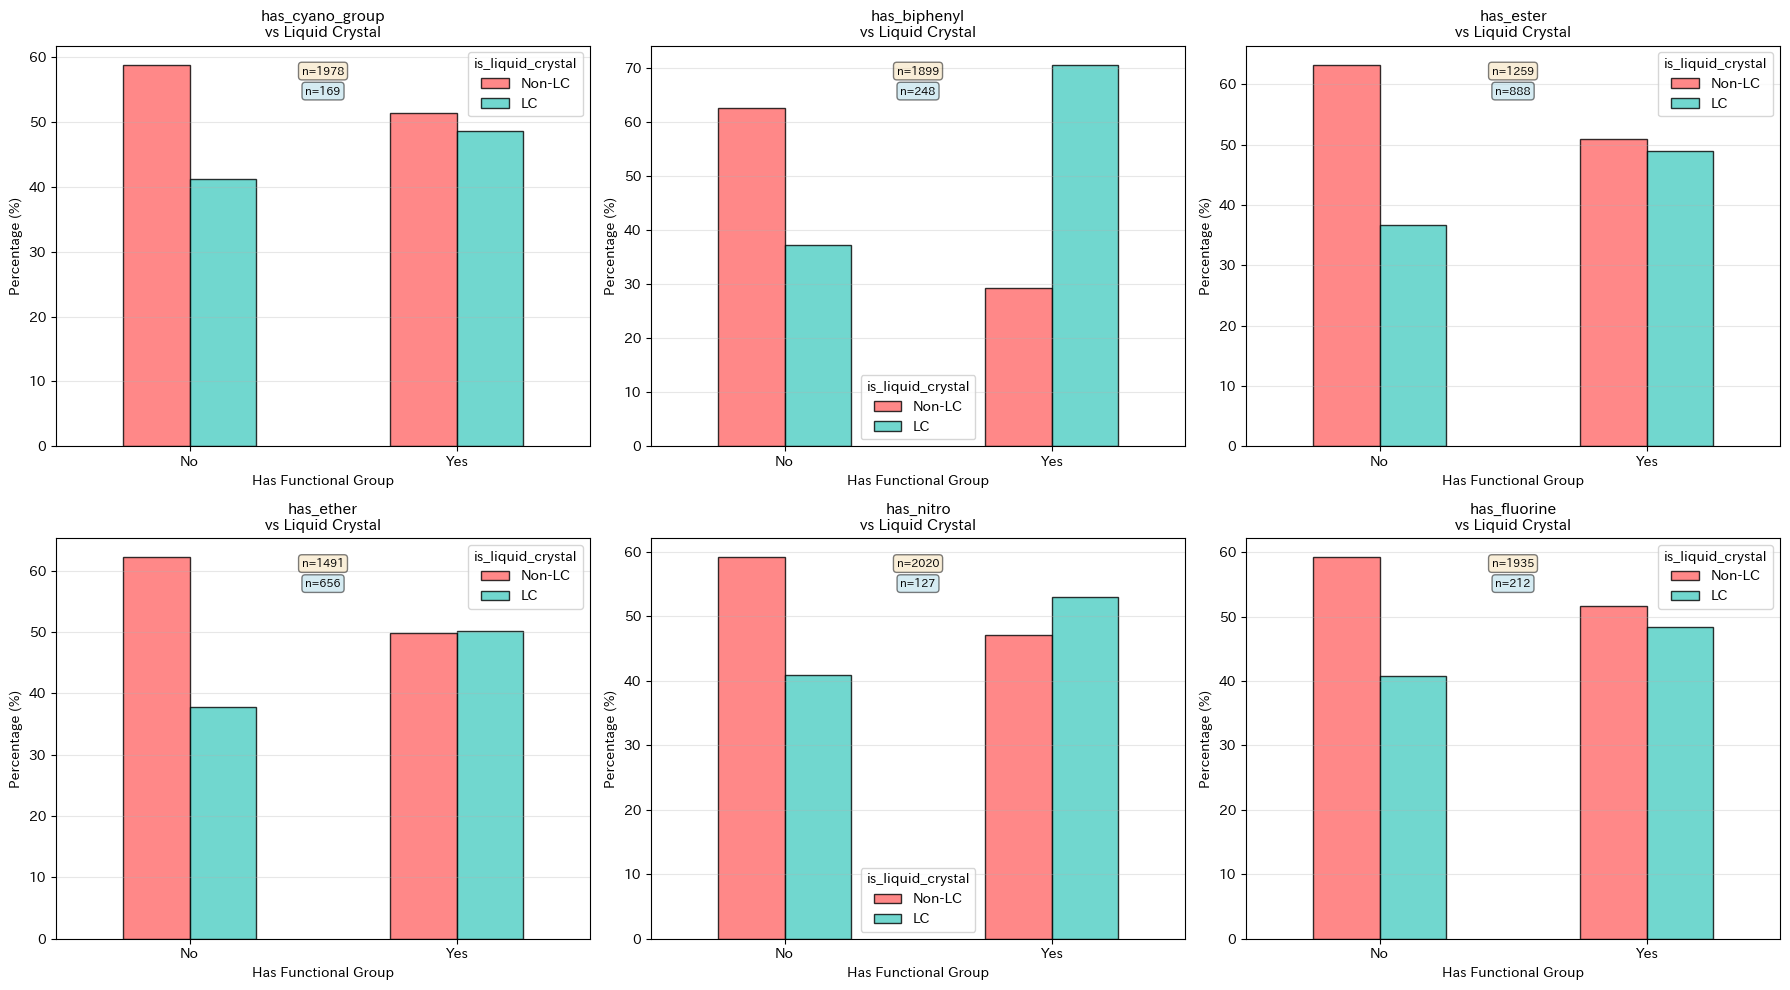

In [17]:
# 官能基の分布を可視化
def visualize_functional_groups(df: pl.DataFrame):
    """
    官能基の分布と液晶性の関係を可視化
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    df_pd = df.to_pandas()
    
    functional_groups = [
        'has_cyano_group', 'has_biphenyl', 'has_ester', 
        'has_ether', 'has_nitro', 'has_fluorine'
    ]
    
    for idx, fg in enumerate(functional_groups):
        ax = axes[idx]
        
        # 官能基の有無 × 液晶性のクロス集計
        crosstab = pd.crosstab(
            df_pd[fg], 
            df_pd['is_liquid_crystal'], 
            normalize='index'
        ) * 100
        
        crosstab.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'], 
                     alpha=0.8, edgecolor='black')
        
        ax.set_title(f'{fg}\nvs Liquid Crystal', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Has Functional Group', fontsize=10, fontweight='bold')
        ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
        ax.set_xticklabels(['No', 'Yes'], rotation=0)
        ax.legend(['Non-LC', 'LC'], title='is_liquid_crystal')
        ax.grid(axis='y', alpha=0.3)
        
        # 実数を表示
        total_false = (df_pd[fg] == False).sum()
        total_true = (df_pd[fg] == True).sum()
        ax.text(0.5, 0.95, f'n={total_false}', transform=ax.transAxes,
               ha='center', va='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.text(0.5, 0.90, f'n={total_true}', transform=ax.transAxes,
               ha='center', va='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('functional_groups_vs_lc.png', dpi=300, bbox_inches='tight')
    plt.show()


# 実行
visualize_functional_groups(df_with_features)

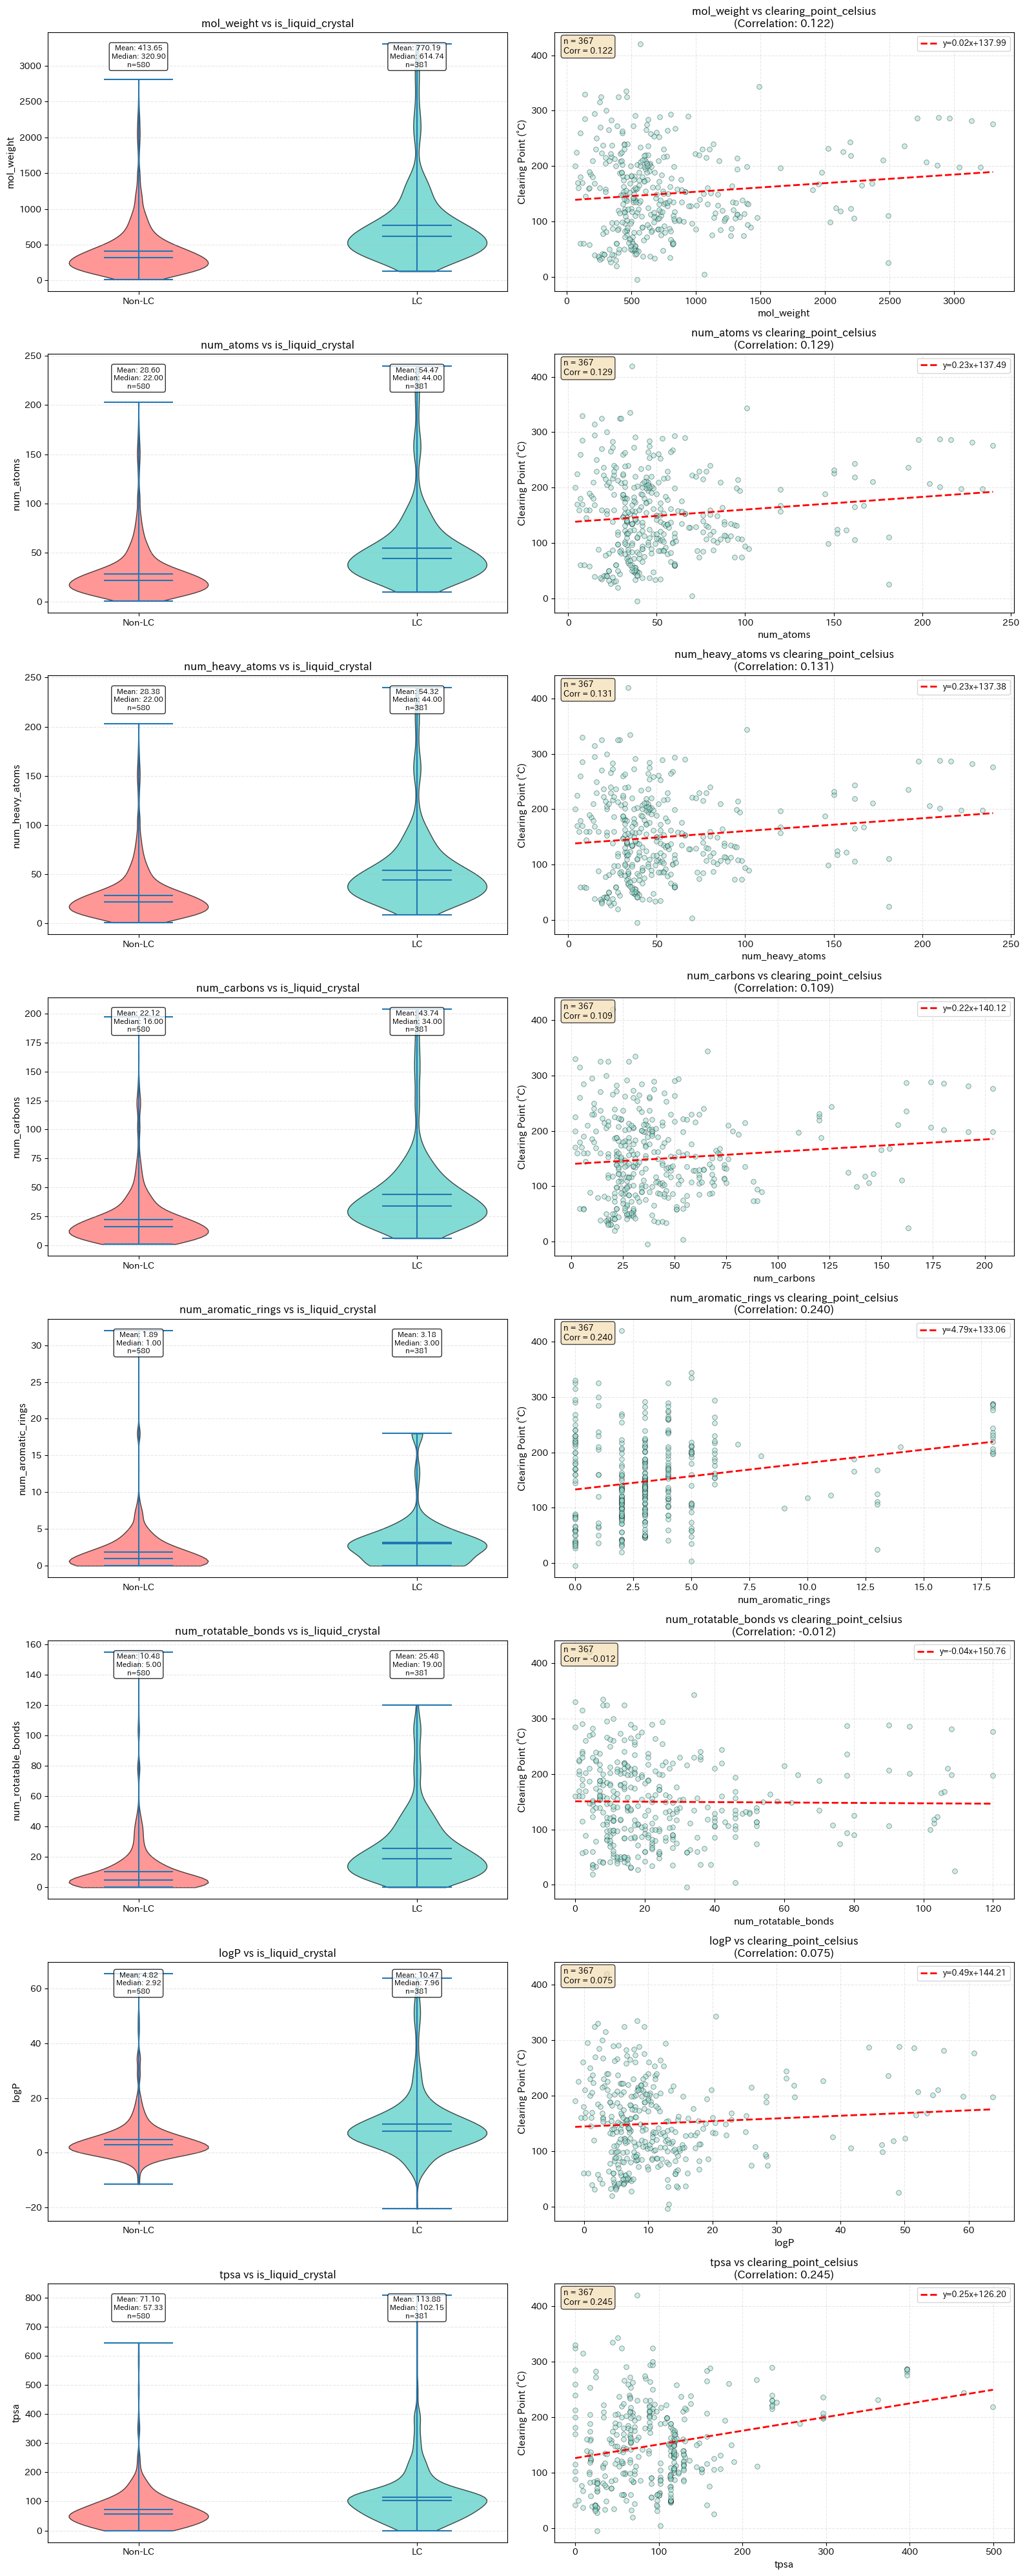

In [18]:
def visualize_features_vs_targets(df: pl.DataFrame):
    """
    基本的な分子記述子と目的変数（is_liquid_crystal, clearing_point_celsius）の関係を可視化
    """
    feature_cols_basic = [
        'mol_weight', 'num_atoms', 'num_heavy_atoms', 'num_carbons',
        'num_aromatic_rings', 'num_rotatable_bonds', 'logP', 'tpsa'
    ]
    
    # 2列 × 8行のサブプロット（左: is_liquid_crystal, 右: clearing_point_celsius）
    fig, axes = plt.subplots(len(feature_cols_basic), 2, figsize=(16, 5 * len(feature_cols_basic)))
    
    df_pd = df.to_pandas()
    
    for idx, feature in enumerate(feature_cols_basic):
        # === 左側: is_liquid_crystal との関係（バイオリンプロット） ===
        ax_left = axes[idx, 0]
        
        # データの準備
        data_to_plot = []
        labels = []
        for lc_val, label in [(False, 'Non-LC'), (True, 'LC')]:
            feature_data = df_pd[df_pd['is_liquid_crystal'] == lc_val][feature].dropna()
            if len(feature_data) > 0:
                data_to_plot.append(feature_data)
                labels.append(label)
        
        if data_to_plot:
            # バイオリンプロット
            parts = ax_left.violinplot(data_to_plot, positions=range(len(data_to_plot)),
                                       showmeans=True, showmedians=True, showextrema=True)
            
            # 色付け
            colors = ['#FF6B6B', '#4ECDC4']
            for pc, color in zip(parts['bodies'], colors[:len(data_to_plot)]):
                pc.set_facecolor(color)
                pc.set_alpha(0.7)
                pc.set_edgecolor('black')
            
            # 統計情報を追加
            for i, (data, label) in enumerate(zip(data_to_plot, labels)):
                mean_val = np.mean(data)
                median_val = np.median(data)
                stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nn={len(data)}'
                ax_left.text(i, ax_left.get_ylim()[1] * 0.95, stats_text,
                           ha='center', va='top', fontsize=8,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax_left.set_xticks(range(len(labels)))
            ax_left.set_xticklabels(labels, fontsize=10, fontweight='bold')
            ax_left.set_ylabel(feature, fontsize=11, fontweight='bold')
            ax_left.set_title(f'{feature} vs is_liquid_crystal', 
                            fontsize=12, fontweight='bold')
            ax_left.grid(axis='y', alpha=0.3, linestyle='--')
        
        # === 右側: clearing_point_celsius との関係（散布図） ===
        ax_right = axes[idx, 1]
        
        # clearing_point が存在するデータのみ
        scatter_data = df_pd[[feature, 'clearing_point_celsius']].dropna()
        
        if len(scatter_data) > 0:
            # 散布図
            ax_right.scatter(scatter_data[feature], scatter_data['clearing_point_celsius'],
                           alpha=0.5, s=30, color='#95E1D3', edgecolor='black', linewidth=0.5)
            
            # 回帰直線を追加
            z = np.polyfit(scatter_data[feature], scatter_data['clearing_point_celsius'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(scatter_data[feature].min(), scatter_data[feature].max(), 100)
            ax_right.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
            
            # 相関係数を計算
            corr = scatter_data[feature].corr(scatter_data['clearing_point_celsius'])
            
            ax_right.set_xlabel(feature, fontsize=11, fontweight='bold')
            ax_right.set_ylabel('Clearing Point (°C)', fontsize=11, fontweight='bold')
            ax_right.set_title(f'{feature} vs clearing_point_celsius\n(Correlation: {corr:.3f})', 
                             fontsize=12, fontweight='bold')
            ax_right.grid(alpha=0.3, linestyle='--')
            ax_right.legend(fontsize=9)
            
            # 統計情報
            stats_text = f'n = {len(scatter_data)}\nCorr = {corr:.3f}'
            ax_right.text(0.02, 0.98, stats_text, transform=ax_right.transAxes,
                        fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        else:
            ax_right.text(0.5, 0.5, 'No data available',
                        ha='center', va='center', fontsize=12, transform=ax_right.transAxes)
            ax_right.axis('off')
    
    plt.tight_layout()
    plt.savefig('features_vs_targets_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()


# 実行
visualize_features_vs_targets(df_with_features)

🔬 分子量による分子構造の可視化
📉 分子量が小さい順に4つ + 📈 分子量が大きい順に4つを表示

分子量の範囲:
  最小: 12.01
  最大: 3301.32
  平均: 519.60
  中央値: 418.44
✅ 有効な分子数: 8 / 目標: 8


[07:01:35] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[07:01:35] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[07:01:35] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

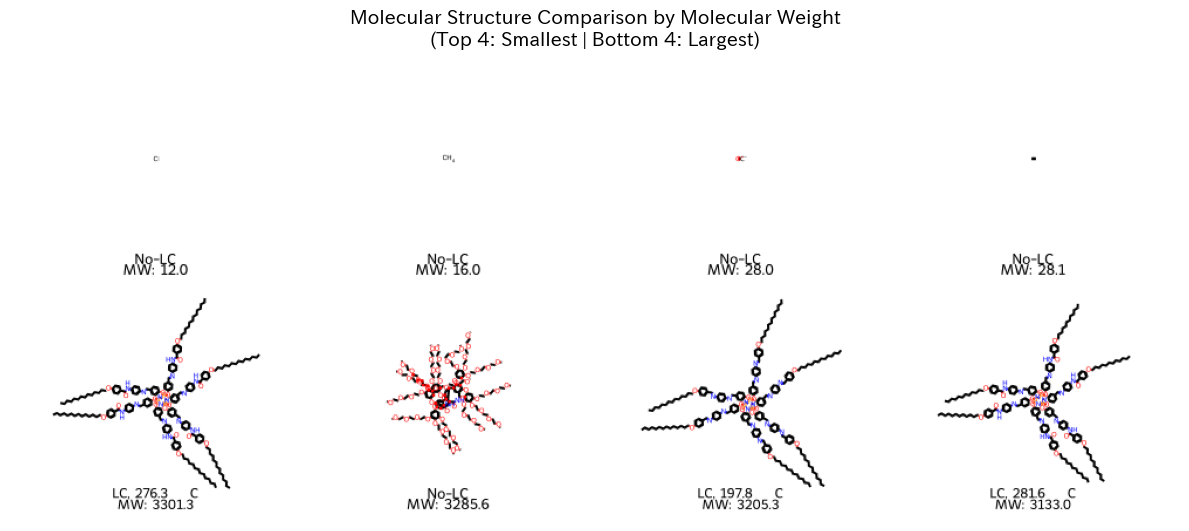

In [19]:
def visualize_molecules_by_weight(df: pl.DataFrame, smiles_col='smiles_guess', num=8):
    """
    分子量でソートして分子構造を可視化（無効なSMILESをスキップ）
    
    Args:
        df: Polars DataFrame
        smiles_col: SMILES列名
        num: 可視化する分子数
    """
    # 分子量でソート
    df_sorted = df.sort('mol_weight')
    
    # 有効な分子のみを収集
    valid_mols_small = []
    valid_mols_large = []
    
    # 小さい順から有効な分子を収集
    for row in df_sorted.iter_rows(named=True):
        if len(valid_mols_small) >= num // 2:
            break
        
        smiles = row[smiles_col]
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is not None:  # 有効な分子のみ
            try:
                # Kekulizationのテスト
                Chem.Kekulize(mol)
                valid_mols_small.append(row)
            except:
                # Kekulization失敗は無視
                continue
    
    # 大きい順から有効な分子を収集（逆順で取得）
    for row in df_sorted.reverse().iter_rows(named=True):
        if len(valid_mols_large) >= num // 2:
            break
        
        smiles = row[smiles_col]
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is not None:
            try:
                Chem.Kekulize(mol)
                valid_mols_large.append(row)
            except:
                continue
    
    # 選択された行を結合
    selected_rows = valid_mols_small + valid_mols_large
    
    print(f"✅ 有効な分子数: {len(selected_rows)} / 目標: {num}")
    
    if len(selected_rows) == 0:
        print("⚠️ 有効な分子が見つかりませんでした")
        return None
    
    mols = []
    legends = []
    
    for row in selected_rows:
        smiles = row[smiles_col]
        mol = Chem.MolFromSmiles(smiles)
        
        if mol:
            mols.append(mol)
            
            # ラベル作成
            is_lc = row.get('is_liquid_crystal', False)
            mol_weight = row.get('mol_weight', 0)
            clearing_temp = row.get('clearing_point_celsius', None)
            
            label = "LC" if is_lc else "No-LC"
            temp = f", {clearing_temp:.1f}°C" if (is_lc and clearing_temp is not None) else ""
            weight_label = f"MW: {mol_weight:.1f}"
            
            legends.append(f"{label}{temp}\n{weight_label}")
    
    # グリッド画像を生成
    img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=4, 
        subImgSize=(250, 200), 
        legends=legends,
        returnPNG=False
    )
    
    return img


# 実行
print("🔬 分子量による分子構造の可視化")
print("=" * 60)
print("📉 分子量が小さい順に4つ + 📈 分子量が大きい順に4つを表示")
print("=" * 60)

# 分子量でソート
df_sorted = df_with_features.sort('mol_weight')

# 統計情報を表示
print(f"\n分子量の範囲:")
print(f"  最小: {df_sorted['mol_weight'].min():.2f}")
print(f"  最大: {df_sorted['mol_weight'].max():.2f}")
print(f"  平均: {df_sorted['mol_weight'].mean():.2f}")
print(f"  中央値: {df_sorted['mol_weight'].median():.2f}")

# 可視化
img = visualize_molecules_by_weight(df_sorted, num=8)

if img is not None:
    # 画像を表示
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure Comparison by Molecular Weight\n(Top 4: Smallest | Bottom 4: Largest)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('molecules_by_weight.png', dpi=300, bbox_inches='tight')
    plt.show()

> 一番小さい分子はCそのものだったりした.   
> 幾つか無効と判定されて可視化できないSMILESのものがある??

In [20]:
# 幾らか無効なSMILESがある？

def check_invalid_smiles(df: pl.DataFrame, smiles_col='smiles_guess'):
    """
    無効なSMILES文字列をチェック
    """
    invalid_count = 0
    valid_count = 0
    kekulize_error_count = 0
    
    for idx, row in enumerate(df.iter_rows(named=True)):
        smiles = row[smiles_col]
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is None:
            invalid_count += 1
            if idx < 5:  # 最初の5個だけ表示
                print(f"❌ Invalid SMILES: {smiles[:50]}...")
        else:
            try:
                Chem.Kekulize(mol)
                valid_count += 1
            except Exception as e:
                kekulize_error_count += 1
                if kekulize_error_count <= 5:  # 最初の5個だけ表示
                    print(f"⚠️ Kekulization error: {smiles[:50]}...")
    
    total = df.height
    print(f"\n📊 SMILES検証結果:")
    print(f"  総数: {total}")
    print(f"  ✅ 有効: {valid_count} ({valid_count/total*100:.1f}%)")
    print(f"  ❌ 無効: {invalid_count} ({invalid_count/total*100:.1f}%)")
    print(f"  ⚠️ Kekulization エラー: {kekulize_error_count} ({kekulize_error_count/total*100:.1f}%)")


# チェック実行
check_invalid_smiles(df_with_features)

[07:01:36] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[07:01:36] Explicit valence for atom # 5 N, 3, is greater than permitted
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

❌ Invalid SMILES: CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3nc4nn(c5ccc(OCCCCCCC...
❌ Invalid SMILES: CCCCCCCCCCCCc1csc(c2csc(c3cc(CCCCCCCCCCCC)s3)s2)c1...


[07:01:36] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 29
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 61 62 63 64 65 66 67
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[07:01:36] Explicit valence for atom # 38 N, 4, is greater than permitted
[07:01:36] Explicit valence for atom # 23 C, 5, is greater than permitted
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[07:01:36] Ex


📊 SMILES検証結果:
  総数: 2147
  ✅ 有効: 2021 (94.1%)
  ❌ 無効: 126 (5.9%)
  ⚠️ Kekulization エラー: 0 (0.0%)


[07:01:36] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 22 30 31 33 34
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 18 19 26 33 34 35 36 43 67 74 75
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 19 27 28 30 31
[07:01:36] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27 28 29 30 31


### 🔍 無効なSMILESの原因

#### 1. **Kekulization エラー ≠ SMILES記法エラー**

今回のエラーは `Can't kekulize mol` なので、実は**SMILES記法自体は正しい**可能性が高いです。

### 🎯 Kekulization エラーの意味

#### **Kekulizationとは？**

芳香族化合物の電子の非局在化（共鳴構造）を、明示的な単結合・二重結合の交互パターンに変換する処理です。

```
例: ベンゼン
  SMILES表記: c1ccccc1 (小文字 c = 芳香族炭素)
  
  Kekulization後:
    C1=CC=CC=C1  (明示的な単結合・二重結合)
```

#### **Kekulization が失敗する原因**

1. **ラジカルや不対電子を持つ構造**
2. **特殊な芳香族系（非ベンゼン型）**
3. **金属錯体や配位結合**
4. **ポリマー構造（`*`を含む）**

---

### ✅ 特徴量計算への影響

#### **重要: Kekulization失敗でも特徴量計算は可能！**

---

### 📋 結論と推奨事項

| 状況 | 特徴量計算 | 構造可視化 | 対応 |
|:---|:---:|:---:|:---|
| **✅ 完全に有効なSMILES** | ⭕ | ⭕ | そのまま使用 |
| **⚠️ Kekulization エラー** | ⭕ | ❌ | **特徴量はそのまま使用OK**<br>可視化時はスキップ |
| **❌ SMILES解析エラー** | ❌ | ❌ | 該当行を除外するか要調査 |

---


### 🎯 最終的な答え

**✅ 特徴量設計にはそのまま使って問題ありません！**

- Kekulizationエラーは**描画の問題**であって、**化学的には正しい構造**
- 分子量、原子数、LogPなどの特徴量は正確に計算されています
- モデル学習には全データを使用可能
- 可視化だけ有効な分子を選択すればOK

# 4. `compound_name`, `phase_transition_behavior`からの特徴量抽出
---
### a. 🏷️ `compound_name` からの特徴量抽出

化合物名には構造情報が含まれていることが多いです。

| 特徴量 | 予想される関係性 |
|:---|:---|
| `name_has_biphenyl_in_name` | ✅ **強い正の相関**: ビフェニル骨格は液晶の典型構造 |
| `name_has_cyano_in_name` | ✅ **正の相関**: シアノ基は液晶材料で頻用 |
| `name_alkyl_chain_mentioned` | ✅ **正の相関**: 長鎖アルキル基 |
| `name_has_poly_prefix` | ⚠️ **要確認**: ポリマー液晶の可能性 |
| `name_has_oxy_in_name` | ✅ **正の相関**: エーテル・エステル結合 |

### b. 🌡️ `phase_transition_behavior` からの特徴量抽出

相転移挙動には温度情報や相の種類が含まれています。

| 特徴量 | 予想される関係性 |
|:---|:---|
| `phase_has_nematic_phase` | ✅ **強い正の相関**: ネマティック相は最も一般的 |
| `phase_first_transition_temp` | 🎯 **clearing_pointと相関**: 最初の転移温度 |
| `phase_highest_transition_temp` | 🎯 **clearing_pointに近い**: 透明点に相当する可能性 |
| `phase_num_phase_transitions` | ✅ **正の相関**: 転移が多い = 液晶性が高い |
| `phase_has_monotropic` | ⚠️ **特殊ケース**: モノトロピック液晶 |

---

In [21]:
def extract_features_from_compound_name(name: str) -> dict:
    """
    化合物名から特徴量を抽出
    
    Args:
        name: 化合物名
    
    Returns:
        特徴量の辞書
    """
    if not isinstance(name, str) or name is None:
        return {
            'name_length': 0,
            'has_alkyl_in_name': False,
            'has_phenyl_in_name': False,
            'has_biphenyl_in_name': False,
            'has_cyano_in_name': False,
            'has_ester_in_name': False,
            'has_oxy_in_name': False,
            'has_methyl_in_name': False,
            'has_ethyl_in_name': False,
            'has_propyl_in_name': False,
            'has_butyl_in_name': False,
            'has_pentyl_in_name': False,
            'has_hexyl_in_name': False,
            'has_octyl_in_name': False,
            'num_digits_in_name': 0,
            'num_hyphens': 0,
            'num_brackets': 0,
            'has_poly_prefix': False,
            'has_bis_tris_in_name': False,
            'alkyl_chain_mentioned': 0,
        }
    
    name_lower = name.lower()
    
    features = {
        # 基本的な特徴
        'name_length': len(name),
        'num_digits_in_name': len(re.findall(r'\d', name)),
        'num_hyphens': name.count('-'),
        'num_brackets': name.count('(') + name.count('['),
        
        # 重要な官能基・構造のキーワード
        'has_alkyl_in_name': bool(re.search(r'alkyl', name_lower)),
        'has_phenyl_in_name': bool(re.search(r'phenyl', name_lower)),
        'has_biphenyl_in_name': bool(re.search(r'biphenyl', name_lower)),
        'has_cyano_in_name': bool(re.search(r'cyano', name_lower)),
        'has_ester_in_name': bool(re.search(r'ester', name_lower)),
        'has_oxy_in_name': bool(re.search(r'oxy', name_lower)),
        
        # アルキル鎖の長さ
        'has_methyl_in_name': bool(re.search(r'methyl', name_lower)),
        'has_ethyl_in_name': bool(re.search(r'ethyl', name_lower)),
        'has_propyl_in_name': bool(re.search(r'propyl', name_lower)),
        'has_butyl_in_name': bool(re.search(r'butyl', name_lower)),
        'has_pentyl_in_name': bool(re.search(r'pentyl', name_lower)),
        'has_hexyl_in_name': bool(re.search(r'hexyl', name_lower)),
        'has_octyl_in_name': bool(re.search(r'octyl', name_lower)),
        'has_decyl_in_name': bool(re.search(r'decyl', name_lower)),
        'has_dodecyl_in_name': bool(re.search(r'dodecyl', name_lower)),
        
        # ポリマー
        'has_poly_prefix': bool(re.search(r'^poly', name_lower)),
        
        # 多置換
        'has_bis_tris_in_name': bool(re.search(r'bis|tris|tetrakis', name_lower)),
    }
    
    # アルキル鎖の炭素数を推定（名前に含まれる数字から）
    alkyl_keywords = ['methyl', 'ethyl', 'propyl', 'butyl', 'pentyl', 
                      'hexyl', 'heptyl', 'octyl', 'nonyl', 'decyl', 'dodecyl']
    alkyl_carbons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
    
    max_alkyl = 0
    for keyword, carbons in zip(alkyl_keywords, alkyl_carbons):
        if keyword in name_lower:
            max_alkyl = max(max_alkyl, carbons)
    
    features['alkyl_chain_mentioned'] = max_alkyl
    
    return features


def add_name_features_to_df(df: pl.DataFrame) -> pl.DataFrame:
    """
    compound_nameから特徴量を抽出してDataFrameに追加
    """
    print("🏷️ 化合物名から特徴量を抽出中...")
    
    df_pd = df.to_pandas()
    
    # 各行に対して特徴量を抽出
    features_list = []
    for idx, name in enumerate(df_pd['compound_name']):
        if idx % 200 == 0:
            print(f"処理中: {idx}/{len(df_pd)}")
        features_list.append(extract_features_from_compound_name(name))
    
    # 特徴量をDataFrameに変換
    features_df = pd.DataFrame(features_list)
    
    # カラム名にプレフィックスを追加
    features_df.columns = [f'name_{col}' for col in features_df.columns]
    
    # 元のDataFrameと結合
    result_df = pd.concat([df_pd, features_df], axis=1)
    
    print("✅ 特徴量抽出完了!")
    return pl.from_pandas(result_df)

In [22]:
def extract_features_from_phase_transition(behavior: str) -> dict:
    """
    phase_transition_behaviorから特徴量を抽出
    
    典型的なフォーマット例:
    - "Cr 24 N 35 Iso"  → 結晶 24℃ → ネマティック 35℃ → 等方性
    - "Cr 147 I (N 97 I)" → 結晶 147℃ → 等方性 (モノトロピック: N 97℃)
    - "M 240 I" → メソフェーズ 240℃ → 等方性
    
    Args:
        behavior: 相転移挙動の文字列
    
    Returns:
        特徴量の辞書
    """
    if not isinstance(behavior, str) or behavior is None:
        return {
            'num_phase_transitions': 0,
            'has_nematic_phase': False,
            'has_smectic_phase': False,
            'has_cholesteric_phase': False,
            'has_columnar_phase': False,
            'has_crystal_phase': False,
            'has_isotropic_phase': False,
            'has_mesophase': False,
            'first_transition_temp': None,
            'highest_transition_temp': None,
            'temp_range': None,
            'num_temperatures': 0,
            'has_monotropic': False,
            'has_decomposition': False,
            'phase_complexity': 0,
        }
    
    behavior_upper = behavior.upper()
    
    # 温度を抽出（数字 + 小数点を含む可能性）
    temperatures = re.findall(r'\d+\.?\d*', behavior)
    temperatures = [float(t) for t in temperatures]
    
    # 液晶相の種類を検出
    features = {
        # 相の種類
        'has_nematic_phase': bool(re.search(r'\bN\b', behavior_upper)),
        'has_smectic_phase': bool(re.search(r'\bS[A-Z]?\b', behavior_upper)),
        'has_cholesteric_phase': bool(re.search(r'\bC\*|CHOLESTERIC', behavior_upper)),
        'has_columnar_phase': bool(re.search(r'\bCOL|COLUMNAR', behavior_upper)),
        'has_crystal_phase': bool(re.search(r'\bCR\b|CRYSTAL', behavior_upper)),
        'has_isotropic_phase': bool(re.search(r'\bI\b|ISO', behavior_upper)),
        'has_mesophase': bool(re.search(r'\bM\b|MESO', behavior_upper)),
        
        # 特殊な挙動
        'has_monotropic': bool(re.search(r'\(.*\)|MONOTROPIC', behavior_upper)),
        'has_decomposition': bool(re.search(r'DEC|DECOMP', behavior_upper)),
        
        # 温度関連
        'num_temperatures': len(temperatures),
        'first_transition_temp': temperatures[0] if temperatures else None,
        'highest_transition_temp': max(temperatures) if temperatures else None,
        'temp_range': max(temperatures) - min(temperatures) if len(temperatures) > 1 else 0,
        
        # 複雑さ
        'num_phase_transitions': len(temperatures),
        'phase_complexity': len(re.findall(r'\b[A-Z]+\b', behavior_upper)),
    }
    
    return features


def add_phase_transition_features_to_df(df: pl.DataFrame) -> pl.DataFrame:
    """
    phase_transition_behaviorから特徴量を抽出してDataFrameに追加
    """
    print("🌡️ 相転移挙動から特徴量を抽出中...")
    
    df_pd = df.to_pandas()
    
    # 各行に対して特徴量を抽出
    features_list = []
    for idx, behavior in enumerate(df_pd['phase_transition_behavior']):
        if idx % 200 == 0:
            print(f"処理中: {idx}/{len(df_pd)}")
        features_list.append(extract_features_from_phase_transition(behavior))
    
    # 特徴量をDataFrameに変換
    features_df = pd.DataFrame(features_list)
    
    # カラム名にプレフィックスを追加
    features_df.columns = [f'phase_{col}' for col in features_df.columns]
    
    # 元のDataFrameと結合
    result_df = pd.concat([df_pd, features_df], axis=1)
    
    print("✅ 特徴量抽出完了!")
    return pl.from_pandas(result_df)

In [23]:
def extract_all_text_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    全てのテキスト特徴量を抽出
    """
    sep("📝 テキスト特徴量の抽出開始")
    
    # 1. compound_name
    df = add_name_features_to_df(df)
    
    # 2. phase_transition_behavior (trainのみ存在)
    if 'phase_transition_behavior' in df.columns:
        df = add_phase_transition_features_to_df(df)
    
    return df

In [24]:
# 実行
df_with_text_features = extract_all_text_features(df_with_features)

📝 テキスト特徴量の抽出開始
🏷️ 化合物名から特徴量を抽出中...
処理中: 0/2147
処理中: 200/2147
処理中: 400/2147
処理中: 600/2147
処理中: 800/2147
処理中: 1000/2147
処理中: 1200/2147
処理中: 1400/2147
処理中: 1600/2147
処理中: 1800/2147
処理中: 2000/2147
✅ 特徴量抽出完了!
🌡️ 相転移挙動から特徴量を抽出中...
処理中: 0/2147
処理中: 200/2147
処理中: 400/2147
処理中: 600/2147
処理中: 800/2147
処理中: 1000/2147
処理中: 1200/2147
処理中: 1400/2147
処理中: 1600/2147
処理中: 1800/2147
処理中: 2000/2147
✅ 特徴量抽出完了!


In [25]:
# 抽出された特徴量を確認
sep("📊 抽出されたテキスト特徴量")

name_feature_cols = [col for col in df_with_text_features.columns if col.startswith('name_')]
print(f"\n🏷️ compound_name から抽出: {len(name_feature_cols)}個")
print(name_feature_cols[:10], "...")

if 'phase_transition_behavior' in df_with_features.columns:
    phase_feature_cols = [col for col in df_with_text_features.columns if col.startswith('phase_')]
    print(f"\n🌡️ phase_transition_behavior から抽出: {len(phase_feature_cols)}個")
    print(phase_feature_cols)

# 統計情報
display(df_with_text_features.select(name_feature_cols[:5]).describe())

📊 抽出されたテキスト特徴量

🏷️ compound_name から抽出: 22個
['name_name_length', 'name_num_digits_in_name', 'name_num_hyphens', 'name_num_brackets', 'name_has_alkyl_in_name', 'name_has_phenyl_in_name', 'name_has_biphenyl_in_name', 'name_has_cyano_in_name', 'name_has_ester_in_name', 'name_has_oxy_in_name'] ...

🌡️ phase_transition_behavior から抽出: 16個
['phase_transition_behavior', 'phase_has_nematic_phase', 'phase_has_smectic_phase', 'phase_has_cholesteric_phase', 'phase_has_columnar_phase', 'phase_has_crystal_phase', 'phase_has_isotropic_phase', 'phase_has_mesophase', 'phase_has_monotropic', 'phase_has_decomposition', 'phase_num_temperatures', 'phase_first_transition_temp', 'phase_highest_transition_temp', 'phase_temp_range', 'phase_num_phase_transitions', 'phase_phase_complexity']


statistic,name_name_length,name_num_digits_in_name,name_num_hyphens,name_num_brackets,name_has_alkyl_in_name
str,f64,f64,f64,f64,f64
"""count""",2147.0,2147.0,2147.0,2147.0,2147.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",45.23428,3.458314,3.25198,1.315324,0.0
"""std""",30.506971,3.988977,3.591221,1.5388,null
"""min""",3.0,0.0,0.0,0.0,0.0
"""25%""",20.0,0.0,0.0,0.0,null
"""50%""",42.0,2.0,2.0,1.0,null
"""75%""",64.0,5.0,5.0,2.0,null
"""max""",178.0,37.0,25.0,8.0,0.0


📊 数値型の特徴量:
  name_features: 22
  phase_features: 15


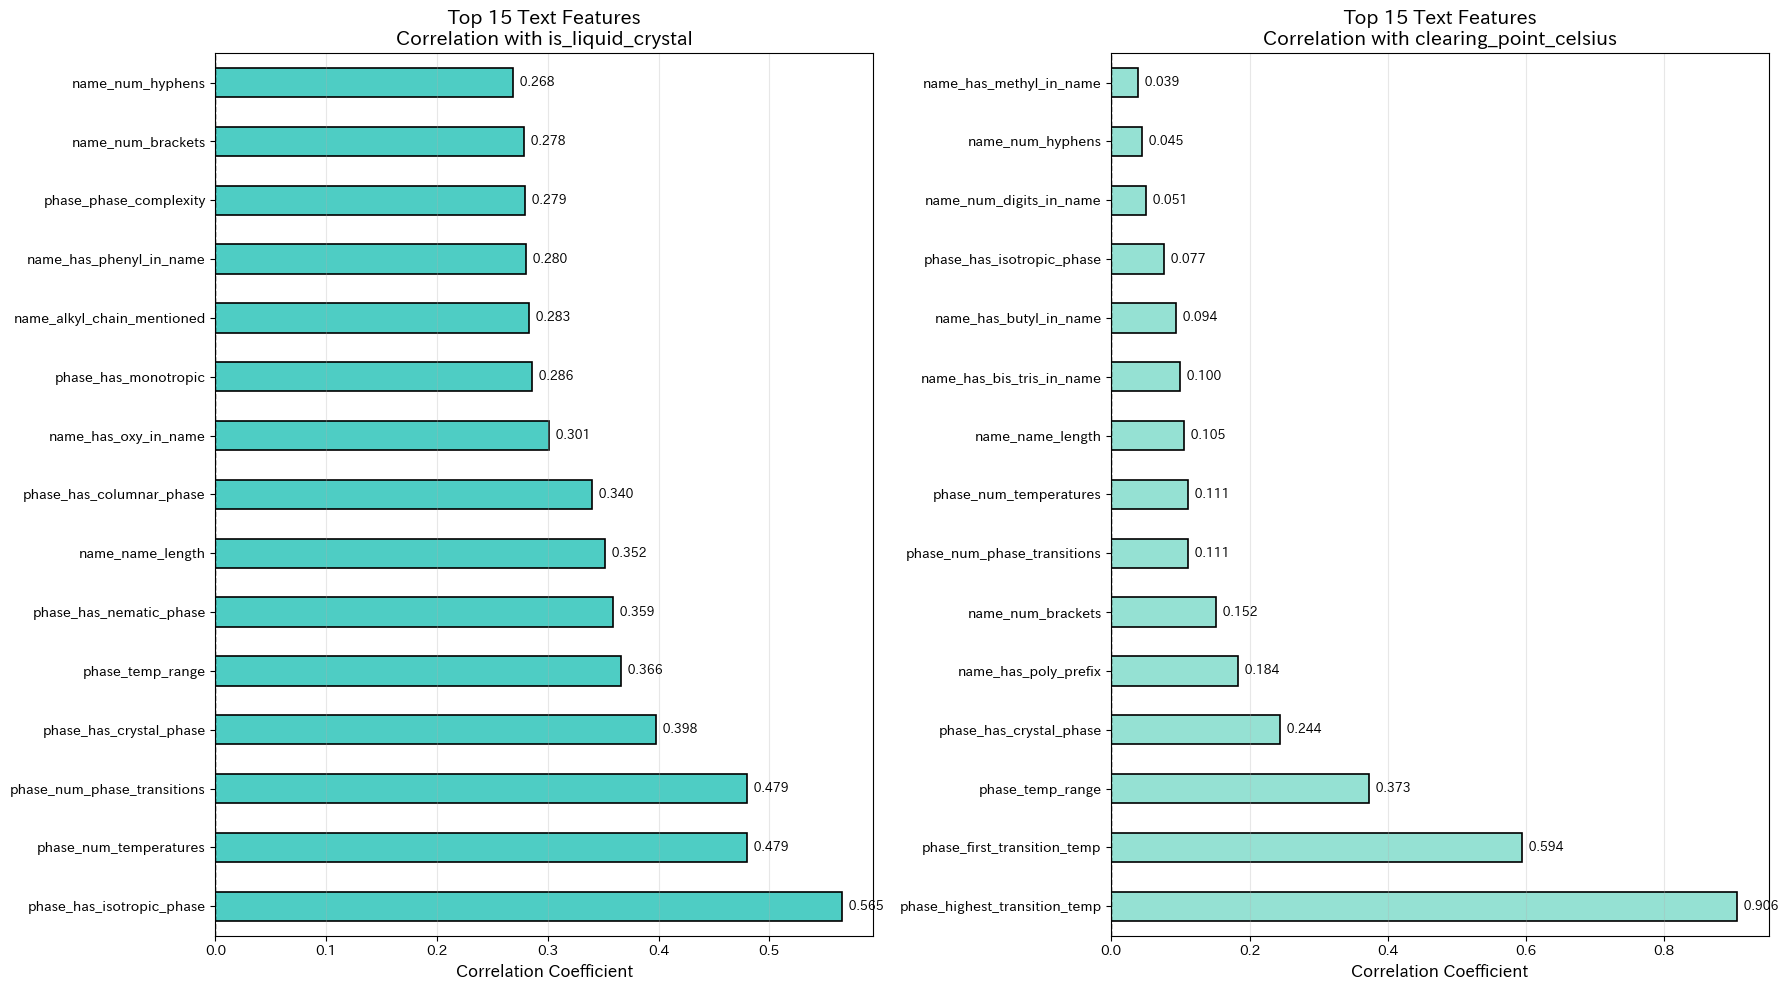

📊 テキスト特徴量と目的変数の相関分析

✅ is_liquid_crystal との相関 (Top 15)
  phase_has_isotropic_phase                         :  0.5653
  phase_num_temperatures                            :  0.4795
  phase_num_phase_transitions                       :  0.4795
  phase_has_crystal_phase                           :  0.3977
  phase_temp_range                                  :  0.3663
  phase_has_nematic_phase                           :  0.3587
  name_name_length                                  :  0.3520
  phase_has_columnar_phase                          :  0.3402
  name_has_oxy_in_name                              :  0.3014
  phase_has_monotropic                              :  0.2860
  name_alkyl_chain_mentioned                        :  0.2827
  name_has_phenyl_in_name                           :  0.2803
  phase_phase_complexity                            :  0.2794
  name_num_brackets                                 :  0.2782
  name_num_hyphens                                  :  0.2682

🌡️ clearing_po

In [26]:
def analyze_text_features_with_both_targets(df: pl.DataFrame):
    """
    テキスト特徴量と両方の目的変数（is_liquid_crystal, clearing_point_celsius）の関係を分析
    """
    # テキスト特徴量を取得（元のテキスト列は除外）
    name_feature_cols = [col for col in df.columns if col.startswith('name_')]
    phase_feature_cols = [col for col in df.columns if col.startswith('phase_')]
    
    # 数値型の特徴量のみをフィルタ
    df_pd = df.to_pandas()
    
    # 数値型またはブール型の列のみを選択
    name_feature_cols_numeric = [
        col for col in name_feature_cols 
        if df_pd[col].dtype in ['int64', 'float64', 'bool', 'int8', 'int32']
    ]
    phase_feature_cols_numeric = [
        col for col in phase_feature_cols 
        if df_pd[col].dtype in ['int64', 'float64', 'bool', 'int8', 'int32']
    ]
    
    print(f"📊 数値型の特徴量:")
    print(f"  name_features: {len(name_feature_cols_numeric)}")
    print(f"  phase_features: {len(phase_feature_cols_numeric)}")
    
    # is_liquid_crystal を数値化
    df_analysis = df.with_columns([
        pl.col('is_liquid_crystal').cast(pl.Int8).alias('is_lc_numeric')
    ])
    
    # 相関を計算
    all_feature_cols = name_feature_cols_numeric + phase_feature_cols_numeric
    corr_data = df_analysis.select(all_feature_cols + ['is_lc_numeric', 'clearing_point_celsius'])
    corr_df = corr_data.to_pandas().corr()
    
    # 2つの目的変数との相関を取得
    lc_corr = corr_df['is_lc_numeric'].drop(['is_lc_numeric', 'clearing_point_celsius']).sort_values(ascending=False)
    temp_corr = corr_df['clearing_point_celsius'].drop(['is_lc_numeric', 'clearing_point_celsius']).sort_values(ascending=False)
    
    # ===== 可視化 =====
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # === 左側: is_liquid_crystal との相関 ===
    ax1 = axes[0]
    
    # 上位15個を表示
    top_lc = lc_corr.head(15)
    colors_lc = ['#4ECDC4' if x > 0 else '#FF6B6B' for x in top_lc.values]
    
    top_lc.plot(kind='barh', ax=ax1, color=colors_lc, edgecolor='black', linewidth=1.2)
    ax1.set_title('Top 15 Text Features\nCorrelation with is_liquid_crystal', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.grid(axis='x', alpha=0.3)
    
    # 値をバーに表示
    for i, (idx, val) in enumerate(top_lc.items()):
        ax1.text(val, i, f'  {val:.3f}', va='center',
                ha='left' if val >= 0 else 'right', fontsize=9, fontweight='bold')
    
    # === 右側: clearing_point_celsius との相関 ===
    ax2 = axes[1]
    
    # 上位15個を表示
    top_temp = temp_corr.head(15)
    colors_temp = ['#95E1D3' if x > 0 else '#FFA07A' for x in top_temp.values]
    
    top_temp.plot(kind='barh', ax=ax2, color=colors_temp, edgecolor='black', linewidth=1.2)
    ax2.set_title('Top 15 Text Features\nCorrelation with clearing_point_celsius', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax2.grid(axis='x', alpha=0.3)
    
    # 値をバーに表示
    for i, (idx, val) in enumerate(top_temp.items()):
        if not np.isnan(val):
            ax2.text(val, i, f'  {val:.3f}', va='center',
                    ha='left' if val >= 0 else 'right', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('text_features_both_targets.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ===== 数値での結果表示 =====
    sep("📊 テキスト特徴量と目的変数の相関分析")
    
    print("\n✅ is_liquid_crystal との相関 (Top 15)")
    print("=" * 70)
    for idx, val in top_lc.items():
        print(f"  {idx:50s}: {val:7.4f}")
    
    print("\n🌡️ clearing_point_celsius との相関 (Top 15)")
    print("=" * 70)
    for idx, val in top_temp.items():
        if not np.isnan(val):
            print(f"  {idx:50s}: {val:7.4f}")


# 実行
analyze_text_features_with_both_targets(df_with_text_features)

# ⚠️ This work is under construction